In [15]:
# Project helpers: prefer importing from src module; fallback to in-notebook definitions
try:
    import sys, os
    sys.path.append(os.path.abspath("/home/jordan/oryx/code/repos/fks/src/python"))
    from services.signals.hmm_features import (
        load_price_data, build_features, fit_hmm_and_states, build_signals, objective
    )
    print("Imported helpers from services.signals.hmm_features")
except Exception as e:
    print("Module import failed, using in-notebook helpers. Error:", e)


Imported helpers from services.signals.hmm_features


# Refactor: Data fetching, timeframes, and HMM → Transformer pipeline

This notebook now has clearly separated steps:

- Parameters: symbol, timeframe (1m, 5m, 15m, 1h, 4h, 1d), date range, and data source.
- Data fetching (own cell): loads and resamples OHLCV to selected timeframe.
- Feature engineering: returns/volatility features for HMM.
- HMM training: fit GaussianHMM, infer states, and compute/visualize transition matrix.
- Transformer prep: enrich dataset with HMM state features (one-hot/embedding-ready) for downstream transformer models.

Run cells in order. Adjust only the parameters cell to change symbol/timeframe.

In [5]:
# Dependencies: ensure required packages are installed in this kernel
import importlib, sys, subprocess

def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        return importlib.import_module(name)
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])
        return importlib.import_module(name)

pd = ensure("pandas", "pandas")
np = ensure("numpy", "numpy")
plt = ensure("matplotlib", "matplotlib.pyplot")
sns = ensure("seaborn", "seaborn")
sklearn = ensure("scikit-learn", "sklearn")
hmmlearn_mod = ensure("hmmlearn", "hmmlearn")
yf = ensure("yfinance", "yfinance")

print("Dependencies ready.")

Dependencies ready.


## Simple Up/Down Transition Matrix (yfinance example)

This optional section replicates a simple two-state transition analysis using yfinance data. It labels each day as up/down based on daily returns and computes the transition matrix.

In [ ]:
# yfinance up/down transition analysis
import pandas as pd
import numpy as np

YF_TICKER = "GC=F"  # Comex Gold futures (continuous)
YF_START = "2010-01-01"
YF_END = "2022-04-22"

yf_df = yf.download(YF_TICKER, start=YF_START, end=YF_END, auto_adjust=False, progress=False)

# Safety checks
if yf_df.empty:
    raise RuntimeError("yfinance download returned empty dataframe. Check ticker/date range.")

# Inspect
display(yf_df.tail())

# Label up/down using Adj Close when available, else Close
price_col = "Adj Close" if "Adj Close" in yf_df.columns else "Close"
yf_df["daily_return"] = yf_df[price_col].pct_change()
yf_df["state"] = np.where(yf_df["daily_return"] >= 0, "up", "down")

# Compute 2x2 transition matrix (up/down) using masks to avoid query issues
mask_up = yf_df["state"] == "up"
mask_down = yf_df["state"] == "down"
up_total = int(mask_up.sum())
down_total = int(mask_down.sum())

up_to_up = (int((mask_up & (yf_df["state"].shift(-1) == "up")).sum()) / up_total) if up_total else np.nan
up_to_down = (int((mask_up & (yf_df["state"].shift(-1) == "down")).sum()) / up_total) if up_total else np.nan

down_to_up = (int((mask_down & (yf_df["state"].shift(-1) == "up")).sum()) / down_total) if down_total else np.nan
down_to_down = (int((mask_down & (yf_df["state"].shift(-1) == "down")).sum()) / down_total) if down_total else np.nan

transition_matrix_ud = pd.DataFrame({
    "up": [up_to_up, up_to_down],
    "down": [down_to_up, down_to_down]
}, index=["up", "down"]).round(6)

print(transition_matrix_ud)

# Example multi-step conditional probability (e.g., P(next is up | last 5 were down))
cond_len = 5
numerator = int(((yf_df["state"] == "up")
                 & (yf_df["state"].shift(-1) == "down")
                 & (yf_df["state"].shift(-2) == "down")
                 & (yf_df["state"].shift(-3) == "down")
                 & (yf_df["state"].shift(-4) == "down")
                 & (yf_df["state"].shift(-5) == "down")).sum())

denominator = int(((yf_df["state"].shift(1) == "down")
                   & (yf_df["state"].shift(2) == "down")
                   & (yf_df["state"].shift(3) == "down")
                   & (yf_df["state"].shift(4) == "down")
                   & (yf_df["state"].shift(5) == "down")).sum())

multi_step_prob = (numerator / denominator) if denominator else np.nan
print("P(next=up | last 5 were down):", multi_step_prob)

In [6]:
# Parameters
from datetime import datetime, timedelta

# Instrument and timeframe
SYMBOL = "ES=F"            # E-mini S&P 500 Futures on Yahoo
TIMEFRAME = "5m"           # focus on short-term trading: 1m/5m/15m

# Data source control
DATA_SOURCE = "api"         # 'local' | 'api' | 'auto'
LOCAL_PATH = "./data"       # used if DATA_SOURCE is 'local' or 'auto'

# Date range: for intraday with yfinance use period fallback; keep None
START = None
END = None

# HMM configuration
N_STATES = 4
COVARIANCE_TYPE = "full"
RANDOM_STATE = 42

# Transformer / feature preparation
INCLUDE_ONE_HOT_STATES = True
INCLUDE_STATE_PROBS = True
SEQ_LEN = 64
TARGET_COL = "close"

# Session filtering (intraday)
USE_RTH = True
SESSION_TZ = "America/New_York"
RTH_START = "09:30"
RTH_END = "16:00"

print({
    'SYMBOL': SYMBOL,
    'TIMEFRAME': TIMEFRAME,
    'DATA_SOURCE': DATA_SOURCE,
    'LOCAL_PATH': LOCAL_PATH,
    'START': START,
    'END': END,
    'N_STATES': N_STATES,
    'SEQ_LEN': SEQ_LEN,
    'USE_RTH': USE_RTH,
})

{'SYMBOL': 'ES=F', 'TIMEFRAME': '5m', 'DATA_SOURCE': 'api', 'LOCAL_PATH': './data', 'START': None, 'END': None, 'N_STATES': 4, 'SEQ_LEN': 64, 'USE_RTH': True}


In [7]:
# Data utilities: timeframe mapping, resampling, and fetch
from __future__ import annotations
import os
from typing import Literal, Optional
import pandas as pd

# Map friendly timeframe to pandas offset alias (avoid deprecated 'T')
TF_TO_PANDAS = {
    "1m": "1min",
    "5m": "5min",
    "15m": "15min",
    "1h": "1H",
    "4h": "4H",
    "1d": "1D",
}

# Map friendly timeframe to yfinance intervals
YF_INTERVAL = {
    "1m": "1m",
    "5m": "5m",
    "15m": "15m",
    "1h": "60m",
    "4h": "60m",  # fetch 60m and resample to 4H
    "1d": "1d",
}

# Suggested default periods for intraday yfinance
YF_PERIOD = {
    "1m": "7d",
    "5m": "60d",
    "15m": "60d",
    "1h": "730d",
    "4h": "730d",
}


def _normalize_timeframe(tf: str) -> str:
    if tf not in TF_TO_PANDAS:
        raise ValueError(f"Unsupported timeframe: {tf}. Choose from {list(TF_TO_PANDAS)}")
    return TF_TO_PANDAS[tf]


def _resample_ohlcv(df: pd.DataFrame, rule: str) -> pd.DataFrame:
    # Expect columns: [open, high, low, close, volume]
    ohlc = {
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
    }
    return df.resample(rule).apply(ohlc).dropna()


def _flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        if df.columns.nlevels > 1 and len(df.columns.get_level_values(-1).unique()) == 1:
            df = df.copy()
            df.columns = df.columns.droplevel(-1)
        else:
            df = df.copy()
            df.columns = ["_".join([str(x) for x in tup if str(x) != ""]) for tup in df.columns]
    return df


def _normalize_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    df = _flatten_columns(df)
    df = df.rename(columns={
        "Open": "open",
        "High": "high",
        "Low": "low",
        "Close": "close",
        "Adj Close": "adj_close",
        "Volume": "volume",
    })
    cols = [c for c in ["open", "high", "low", "close", "volume"] if c in df.columns]
    return df[cols]


def load_local_ohlcv(symbol: str, start: Optional[str], end: Optional[str], local_path: str) -> pd.DataFrame:
    candidates = [
        os.path.join(local_path, f"{symbol}.csv"),
        os.path.join(local_path, f"{symbol.lower()}.csv"),
        os.path.join(local_path, symbol, "ohlcv.csv"),
        os.path.join(local_path, symbol, "ohlcv.parquet"),
    ]
    for path in candidates:
        if os.path.exists(path):
            if path.endswith(".parquet"):
                df = pd.read_parquet(path)
            else:
                df = pd.read_csv(path)
            break
    else:
        raise FileNotFoundError(f"No local OHLCV file found for {symbol} under {local_path}")

    cols = {c.lower(): c for c in df.columns}
    time_col = None
    for t in ("timestamp", "time", "date", "datetime"):
        if t in cols:
            time_col = cols[t]
            break
    if time_col is None:
        raise ValueError("Could not find a timestamp column in the local OHLCV file")

    df = df.rename(columns={
        cols.get("open", "open"): "open",
        cols.get("high", "high"): "high",
        cols.get("low", "low"): "low",
        cols.get("close", "close"): "close",
        cols.get("volume", "volume"): "volume",
    })
    df[time_col] = pd.to_datetime(df[time_col], utc=True, errors="coerce")
    df = df.set_index(time_col).sort_index()
    if start:
        df = df.loc[pd.to_datetime(start, utc=True):]
    if end:
        df = df.loc[:pd.to_datetime(end, utc=True)]
    return df[["open", "high", "low", "close", "volume"]]


def load_api_ohlcv(symbol: str, timeframe: str, start: Optional[str], end: Optional[str]) -> pd.DataFrame:
    import yfinance as yf
    interval = YF_INTERVAL[timeframe]
    df = None
    if timeframe != "1d" and (start is None and end is None):
        df = yf.download(symbol, period=YF_PERIOD[timeframe], interval=interval, auto_adjust=False, progress=False)
    else:
        df = yf.download(symbol, start=start, end=end, interval=interval, auto_adjust=False, progress=False)
        if (df is None or df.empty) and timeframe != "1d":
            df = yf.download(symbol, period=YF_PERIOD[timeframe], interval=interval, auto_adjust=False, progress=False)
    if df is None or df.empty:
        raise RuntimeError("API returned empty data")
    df = _flatten_columns(df)
    df.index = pd.to_datetime(df.index, utc=True, errors="coerce")
    df = _normalize_ohlcv(df).dropna()
    rule = _normalize_timeframe(timeframe)
    if timeframe in ("4h",):
        df = _resample_ohlcv(df, rule)
    return df


def fetch_data(symbol: str, timeframe: str, start: Optional[str] = None, end: Optional[str] = None,
               source: Literal["local", "api", "auto"] = "local", local_path: Optional[str] = None) -> pd.DataFrame:
    rule = _normalize_timeframe(timeframe)

    if source == "local":
        if not local_path:
            raise ValueError("local_path is required for source='local'")
        df = load_local_ohlcv(symbol, start, end, local_path)
    elif source == "api":
        df = load_api_ohlcv(symbol, timeframe, start, end)
    elif source == "auto":
        try:
            if local_path:
                df = load_local_ohlcv(symbol, start, end, local_path)
            else:
                raise FileNotFoundError("No local_path provided for auto mode")
        except Exception:
            df = load_api_ohlcv(symbol, timeframe, start, end)
    else:
        raise ValueError("source must be 'local', 'api', or 'auto'")

    if rule != "1min" and timeframe not in ("4h", "1d"):
        df = _resample_ohlcv(df, rule)
    return df

In [16]:
# Data fetching (run this after editing parameters)
import pandas as pd

try:
    df_raw = fetch_data(SYMBOL, TIMEFRAME, START, END, DATA_SOURCE, LOCAL_PATH)
    display(df_raw.tail())
except Exception as e:
    print(f"Data fetch failed: {e}")

Price,open,high,low,close,volume
Datetime,,,,,
2025-08-14 05:55:00+00:00,6479.00,6480.25,6478.75,6480.00,379
2025-08-14 06:00:00+00:00,6479.75,6480.75,6478.50,6480.25,513
2025-08-14 06:05:00+00:00,6480.25,6480.75,6479.75,6479.75,298
2025-08-14 06:10:00+00:00,6479.75,6479.75,6477.25,6477.75,1030
2025-08-14 06:15:00+00:00,6477.75,6479.25,6477.00,6479.00,394


In [12]:
# Optional: filter to regular trading hours (RTH) for intraday
if USE_RTH and TIMEFRAME.endswith('m'):
    _df_local = df_raw.copy()
    try:
        df_ny = _df_local.tz_convert(SESSION_TZ)
    except Exception:
        # if not tz-aware, assume UTC then convert
        df_ny = _df_local.tz_localize('UTC').tz_convert(SESSION_TZ)
    df_ny = df_ny.between_time(RTH_START, RTH_END)
    df_raw = df_ny.tz_convert('UTC')
    print(f"Applied RTH filter: {RTH_START}-{RTH_END} {SESSION_TZ}. Rows: {len(df_raw)}")

Applied RTH filter: 09:30-16:00 America/New_York. Rows: 3675


In [13]:
# Feature engineering → HMM → Transition matrix → Transformer features
import numpy as np
import pandas as pd

# Optional dependency: hmmlearn
try:
    from hmmlearn.hmm import GaussianHMM
except Exception as e:
    raise RuntimeError("Missing dependency hmmlearn. Please install it: pip install hmmlearn scikit-learn")


def engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["ret1"] = out["close"].pct_change()
    out["log_ret1"] = np.log(out["close"]).diff()
    out["hl_range"] = (out["high"] - out["low"]) / out["close"].shift(1)
    out["vol10"] = out["log_ret1"].rolling(10).std()
    out["vol20"] = out["log_ret1"].rolling(20).std()
    out["rsi14"] = rsi(out["close"], 14)
    out = out.dropna()
    return out


def rsi(close: pd.Series, period: int = 14) -> pd.Series:
    delta = close.diff()
    gain = (delta.clip(lower=0)).rolling(period).mean()
    loss = (-delta.clip(upper=0)).rolling(period).mean()
    rs = gain / (loss + 1e-12)
    return 100 - (100 / (1 + rs))


def fit_hmm(X: np.ndarray, n_states: int, covariance_type: str = "full", random_state: int = 42) -> GaussianHMM:
    model = GaussianHMM(n_components=n_states, covariance_type=covariance_type, random_state=random_state, n_iter=200)
    model.fit(X)
    return model


def transition_matrix(model: GaussianHMM) -> np.ndarray:
    # rows: from-state, cols: to-state
    return model.transmat_


def transformer_ready_df(df_feat: pd.DataFrame, states: np.ndarray, model: GaussianHMM,
                         include_one_hot: bool = True, include_state_probs: bool = True) -> pd.DataFrame:
    out = df_feat.copy()
    out["hmm_state"] = states
    if include_one_hot:
        for s in range(model.n_components):
            out[f"state_{s}"] = (states == s).astype(int)
    if include_state_probs:
        probs = model.predict_proba(df_feat[["ret1", "log_ret1", "hl_range", "vol10", "vol20", "rsi14"]])
        for s in range(model.n_components):
            out[f"state_p{s}"] = probs[:, s]
    return out

# 1) Engineer features
features_df = engineered_features(df_raw)
X = features_df[["ret1", "log_ret1", "hl_range", "vol10", "vol20", "rsi14"]].values

# 2) Train HMM and infer states
hmm = fit_hmm(X, N_STATES, COVARIANCE_TYPE, RANDOM_STATE)
states = hmm.predict(X)
trans_mat = transition_matrix(hmm)

print("Transition matrix (rows from-state, cols to-state):\n", np.round(trans_mat, 4))

# 3) Build transformer-ready frame
trans_df = transformer_ready_df(features_df, states, hmm, INCLUDE_ONE_HOT_STATES, INCLUDE_STATE_PROBS)

display(trans_df.tail())

Transition matrix (rows from-state, cols to-state):
 [[0.2519 0.     0.4146 0.3335]
 [0.0115 0.7852 0.2033 0.    ]
 [0.0424 0.4653 0.4875 0.0048]
 [0.0301 0.0237 0.0355 0.9107]]


Price,open,high,low,close,volume,ret1,log_ret1,hl_range,vol10,vol20,rsi14,hmm_state,state_0,state_1,state_2,state_3,state_p0,state_p1,state_p2,state_p3
Datetime,,,,,,,,,,,,,,,,,,,,
2025-08-13 19:40:00+00:00,6480.50,6483.75,6480.00,6481.75,10168,0.000231,0.000231,0.000579,0.000243,0.000321,50.000000,1,0,1,0,0,6.587871e-10,9.983892e-01,0.001611,2.309852e-10
2025-08-13 19:45:00+00:00,6482.00,6484.75,6481.50,6484.25,8852,0.000386,0.000386,0.000501,0.000268,0.000329,69.565217,1,0,1,0,0,1.471174e-07,9.681826e-01,0.031817,6.383437e-09
2025-08-13 19:50:00+00:00,6484.25,6489.75,6484.25,6488.50,23238,0.000655,0.000655,0.000848,0.000327,0.000325,73.750000,2,0,0,1,0,2.976527e-07,2.155873e-08,0.999999,2.112690e-07
2025-08-13 19:55:00+00:00,6488.75,6491.25,6486.75,6489.00,70343,0.000077,0.000077,0.000694,0.000309,0.000308,73.417722,1,0,1,0,0,1.199071e-08,9.618438e-01,0.038155,9.632483e-07
2025-08-13 20:00:00+00:00,6489.00,6493.25,6489.00,6490.75,20142,0.000270,0.000270,0.000655,0.000282,0.000309,74.698795,1,0,1,0,0,5.651669e-08,9.928223e-01,0.007177,4.696423e-07


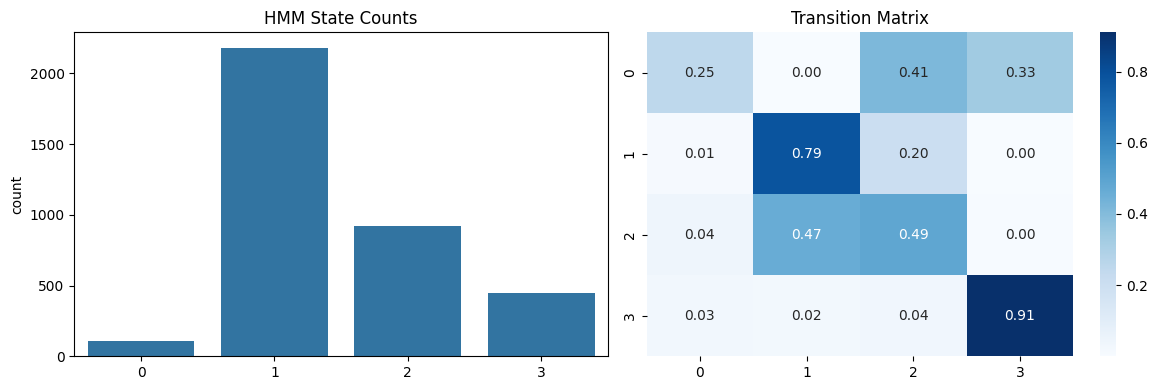

In [14]:
# Quick visuals: state distribution and transition matrix heatmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# State histogram
sns.countplot(x=states, ax=axes[0])
axes[0].set_title("HMM State Counts")
# Transition heatmap
sns.heatmap(trans_mat, annot=True, fmt=".2f", cmap="Blues", ax=axes[1])
axes[1].set_title("Transition Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Deep CUDA diagnostics: environment, device nodes, and raw cuInit()
import os, sys, subprocess, ctypes, platform
print('Python:', sys.version)
print('Executable:', sys.executable)
print('Platform:', platform.platform())
print('CUDA_VISIBLE_DEVICES =', os.environ.get('CUDA_VISIBLE_DEVICES'))

# Device nodes
devs = [p for p in ('/dev/nvidia0','/dev/nvidiactl','/dev/nvidia-uvm','/dev/nvidia-modeset') if os.path.exists(p)]
print('Device nodes present:', devs)
try:
    for p in devs:
        st = os.stat(p)
        print(f'stat {p}: mode={oct(st.st_mode)}, uid={st.st_uid}, gid={st.st_gid}')
except Exception as e:
    print('stat failed:', e)

# Group membership
try:
    import grp
    gids = os.getgroups()
    groups = [grp.getgrgid(g).gr_name for g in gids]
    print('Groups:', groups)
except Exception as e:
    print('Groups check failed:', e)

# nvidia-smi
try:
    out = subprocess.run(['nvidia-smi','-L'], capture_output=True, text=True, check=False)
    print('nvidia-smi -L rc', out.returncode)
    print(out.stdout or out.stderr)
except FileNotFoundError:
    print('nvidia-smi not found in PATH')

# Raw CUDA driver checks via libcuda
try:
    lib = ctypes.CDLL('libcuda.so.1')
    cuInit = lib.cuInit; cuInit.argtypes=[ctypes.c_uint]; cuInit.restype=ctypes.c_int
    cuDeviceGetCount = lib.cuDeviceGetCount; cuDeviceGetCount.argtypes=[ctypes.POINTER(ctypes.c_int)]; cuDeviceGetCount.restype=ctypes.c_int
    cuGetErrorName = lib.cuGetErrorName; cuGetErrorName.argtypes=[ctypes.c_int, ctypes.POINTER(ctypes.c_char_p)]; cuGetErrorName.restype=ctypes.c_int
    cuGetErrorString = lib.cuGetErrorString; cuGetErrorString.argtypes=[ctypes.c_int, ctypes.POINTER(ctypes.c_char_p)]; cuGetErrorString.restype=ctypes.c_int

    err = cuInit(0)
    name_p = ctypes.c_char_p(); cuGetErrorName(err, ctypes.byref(name_p))
    msg_p = ctypes.c_char_p(); cuGetErrorString(err, ctypes.byref(msg_p))
    print('cuInit err=', err, 'name=', name_p.value, 'msg=', msg_p.value)
    if err == 0:
        cnt = ctypes.c_int(0)
        derr = cuDeviceGetCount(ctypes.byref(cnt))
        dname_p = ctypes.c_char_p(); cuGetErrorName(derr, ctypes.byref(dname_p))
        dmsg_p = ctypes.c_char_p(); cuGetErrorString(derr, ctypes.byref(dmsg_p))
        print('cuDeviceGetCount rc=', derr, 'name=', dname_p.value, 'msg=', dmsg_p.value, 'count=', cnt.value)
except OSError as e:
    print('libcuda load FAILED:', e)
except Exception as e:
    import traceback; traceback.print_exc()


# GPU Kernel and Quick Start

- Select the Jupyter kernel named: Python (fks-gpu CUDA).
- Run Cell 1 (GPU diagnostics) to confirm CUDA is available and the GPU name is printed.
- Then run the last cell to launch the unified experiment automatically (it will use CUDA if available, else CPU).


In [ ]:
# GPU diagnostics and kernel guard
import os, sys, platform, subprocess
print('Python:', sys.version)
print('Platform:', platform.platform())
try:
    import torch
    print('Torch:', torch.__version__, 'built CUDA:', getattr(torch.version, 'cuda', None))
    print('CUDA available:', torch.cuda.is_available())
    if torch.cuda.is_available():
        print('Device count:', torch.cuda.device_count())
        print('Current device:', torch.cuda.current_device())
        print('Name:', torch.cuda.get_device_name(0))
    else:
        # Common hints when CUDA isn't available in notebook
        print('Hint: Switch kernel to "Python (fks-gpu CUDA)" once installed, or restart kernel after installing CUDA-enabled torch.')
except Exception as e:
    print('Torch import/init failed:', e)

# Show NV libs presence
for so in ('libcuda.so.1','libnvidia-ml.so.1'):
    try:
        import ctypes
        ctypes.CDLL(so)
        print(so, 'OK')
    except OSError as e:
        print(so, 'FAIL', e)

print('CUDA_VISIBLE_DEVICES =', os.environ.get('CUDA_VISIBLE_DEVICES'))


In [ ]:
# Bootstrap helpers (safe fallbacks if earlier setup cells were not run)
import pandas as pd
import numpy as np

# Provide a minimal yfinance normalizer if missing
if 'standard_normalize_yf' not in globals():
    def standard_normalize_yf(df: pd.DataFrame) -> pd.DataFrame:
        if isinstance(df.columns, pd.MultiIndex):
            df = df.droplevel(0, axis=1)
        out = df.copy()
        out.columns = [str(c).lower() for c in out.columns]
        # Prefer adjusted close as close if present
        if 'adj close' in out.columns and 'close' not in out.columns:
            out = out.rename(columns={'adj close': 'close'})
        # Ensure required OHLCV columns exist
        need = ['open', 'high', 'low', 'close', 'volume']
        for n in need:
            if n not in out.columns:
                if n == 'volume':
                    out[n] = 0.0
                else:
                    # replicate close for missing OHLC
                    out[n] = out['close'] if 'close' in out.columns else out.iloc[:, 0]
        # Enforce datetime index and sort
        if not isinstance(out.index, pd.DatetimeIndex):
            out.index = pd.to_datetime(out.index)
        out = out.sort_index()
        return out[['open','high','low','close','volume']].copy()

# Provide a minimal validator if missing
if 'validate_price_frame' not in globals():
    def validate_price_frame(df: pd.DataFrame, *, need_cols=('close',), min_rows: int=200):
        if df is None or len(df) == 0:
            raise ValueError('Price frame is empty')
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError('Price index must be a DatetimeIndex')
        if not df.index.is_monotonic_increasing:
            df = df.sort_index()
        missing = [c for c in need_cols if c not in df.columns]
        if missing:
            raise KeyError(f'Missing required columns: {missing}')
        if len(df) < min_rows:
            raise ValueError(f'Not enough rows: {len(df)} < {min_rows}')
        return df

# Provide windowize if missing
if 'windowize' not in globals():
    def windowize(X: np.ndarray, y: pd.Series, L: int):
        Xs, Ys, idxs = [], [], []
        for i in range(L, len(X)):
            Xs.append(X[i-L:i])
            Ys.append(y.iloc[i])
            idxs.append(y.index[i])
        return np.array(Xs, dtype=np.float32), np.array(Ys, dtype=np.float32), np.array(idxs)

# Provide metrics if missing
if 'metrics' not in globals():
    def metrics(y_true: np.ndarray, y_pred: np.ndarray):
        y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
        mae = float(np.mean(np.abs(y_true - y_pred)))
        rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
        dir_acc = float(np.mean(np.sign(y_true) == np.sign(y_pred)))
        return {'mae': mae, 'rmse': rmse, 'dir_acc': dir_acc}

print('Bootstrap helpers ready (standard_normalize_yf, validate_price_frame, windowize, metrics).')

In [ ]:
# Quick CUDA diagnostics (optional)
try:
    import torch, sys, os
    print('Python:', sys.version)
    print('Torch:', torch.__version__)
    print('torch.version.cuda:', getattr(torch.version, 'cuda', None))
    print('is_built_with_cuda:', torch.backends.cuda.is_built())
    print('CUDA_VISIBLE_DEVICES:', os.environ.get('CUDA_VISIBLE_DEVICES'))
    print('CUDA available:', torch.cuda.is_available())
    print('Device count:', torch.cuda.device_count())
    if torch.cuda.is_available():
        print('Device 0:', torch.cuda.get_device_name(0))
except Exception as e:
    print('CUDA diagnostics error:', e)

In [ ]:
# Fallback artifacts + run logger (if not already defined)
import json, pickle
from pathlib import Path
import pandas as pd

if 'save_artifacts' not in globals():
    def save_artifacts(out_dir, symbol, artifacts: dict, model=None):
        import torch
        p = Path(out_dir)
        p.mkdir(parents=True, exist_ok=True)
        paths = {}
        if model is not None:
            ck = p / f"{symbol}_best.pt"
            torch.save(model.state_dict(), ck)
            paths['model'] = str(ck)
        if 'hmm' in artifacts:
            fp = p / 'hmm.pkl'
            with open(fp, 'wb') as f:
                pickle.dump(artifacts['hmm'], f)
            paths['hmm'] = str(fp)
        if 'scaler' in artifacts:
            fp = p / 'scaler.pkl'
            with open(fp, 'wb') as f:
                pickle.dump(artifacts['scaler'], f)
            paths['scaler'] = str(fp)
        if 'feat_cols' in artifacts:
            fp = p / 'feat_cols.json'
            with open(fp, 'w') as f:
                json.dump(list(artifacts['feat_cols']), f)
            paths['feat_cols'] = str(fp)
        if 'config' in artifacts:
            fp = p / 'config.json'
            with open(fp, 'w') as f:
                json.dump(artifacts['config'], f, indent=2)
            paths['config'] = str(fp)
        return paths

if 'load_artifacts' not in globals():
    def load_artifacts(out_dir, symbol):
        import torch
        p = Path(out_dir)
        out = {}
        mp = p / f"{symbol}_best.pt"
        if mp.exists():
            out['model_state_dict'] = torch.load(mp, map_location='cpu')
        hp = p / 'hmm.pkl'
        if hp.exists():
            with open(hp, 'rb') as f:
                out['hmm'] = pickle.load(f)
        sp = p / 'scaler.pkl'
        if sp.exists():
            with open(sp, 'rb') as f:
                out['scaler'] = pickle.load(f)
        fp = p / 'feat_cols.json'
        if fp.exists():
            with open(fp, 'r') as f:
                out['feat_cols'] = json.load(f)
        cp = p / 'config.json'
        if cp.exists():
            with open(cp, 'r') as f:
                out['config'] = json.load(f)
        return out

if 'log_run' not in globals():
    def log_run(symbol: str, seed: int, cfg: dict, val_metrics: dict, test_metrics: dict, val_stats: dict, test_stats: dict, out_dir='models'):
        row = {
            'ts': pd.Timestamp.now(tz='UTC').isoformat(),
            'symbol': symbol,
            'seed': seed,
            'horizon': cfg.get('horizon'),
            'seq_len': cfg.get('seq_len'),
            'batch_size': cfg.get('batch_size'),
            'lr': cfg.get('lr'),
            'model': cfg.get('model', {}),
            **{f'val_{k}': float(v) for k,v in val_metrics.items()},
            **{f'test_{k}': float(v) for k,v in test_metrics.items()},
            **{f'val_{k}': float(v) for k,v in val_stats.items()},
            **{f'test_{k}': float(v) for k,v in test_stats.items()},
        }
        p = Path(out_dir) / 'run_log.csv'
        pd.DataFrame([row]).to_csv(p, mode='a', header=not p.exists(), index=False)
        print('Logged run to', p)

In [ ]:
# Robust backtest and perf_stats helpers (override older versions if any)
import pandas as pd
import numpy as np

def _to_close_series(prices):
    if isinstance(prices, pd.DataFrame):
        for key in ['close','Close']:
            if key in prices.columns:
                return prices[key].astype(float)
        # If multiindex columns, try ('close','') style
        for c in prices.columns:
            if isinstance(c, tuple) and str(c[0]).lower() == 'close':
                return prices[c].astype(float)
        # Fallback: first column
        return prices.iloc[:,0].astype(float)
    s = pd.Series(prices)
    s.index = getattr(prices, 'index', s.index)
    return s.astype(float)


def backtest(prices, signals, cost_bps=0, slippage_bps=0):
    px = _to_close_series(prices).dropna()
    rets = px.pct_change().dropna()
    sig = signals
    if isinstance(sig, (list, tuple, np.ndarray)):
        sig = pd.Series(np.asarray(sig, dtype=float))
        # align to rets index from the end
        m = min(len(sig), len(rets))
        sig = pd.Series(sig.values[-m:], index=rets.index[-m:])
        rets = rets.iloc[-m:]
    else:
        sig = pd.Series(sig, index=getattr(sig, 'index', rets.index)).astype(float)
        sig = sig.reindex(rets.index)
    sig = sig.fillna(0.0)

    # Use previous signal for today's return to avoid lookahead
    pos = sig.shift(1).fillna(0.0).clip(-1, 1)
    gross = pos * rets

    # Transaction cost on position changes
    trades = sig.diff().abs().fillna(sig.abs())
    total_bps = float(cost_bps) + float(slippage_bps)
    costs = trades * (total_bps / 1e4)

    net = gross - costs
    equity = (1.0 + net).cumprod()

    # Stats
    if net.std(ddof=0) > 0:
        sharpe = (net.mean() / net.std(ddof=0)) * np.sqrt(252)
    else:
        sharpe = 0.0
    downside = net[net < 0]
    if downside.std(ddof=0) > 0:
        sortino = (net.mean() / downside.std(ddof=0)) * np.sqrt(252)
    else:
        sortino = 0.0
    rollmax = equity.cummax()
    mdd = ((equity / rollmax) - 1.0).min()
    years = max((equity.index[-1] - equity.index[0]).days / 365.25, 1e-9)
    cagr = float(equity.iloc[-1]) ** (1/years) - 1.0 if len(equity) > 0 else 0.0

    stats = {
        'sharpe': float(sharpe),
        'sortino': float(sortino),
        'mdd': float(mdd),
        'cagr': float(cagr),
    }
    return stats, net, equity

print('Backtest helpers ready (robust backtest + perf stats).')

# HMM-Guided Transformer for Trading Signals: Prototype Notebook
This notebook prototypes a hybrid HMM + Transformer pipeline to generate trading signals, evaluate them with backtests, and prepare a forward-testing harness. It runs on CPU by default and can use GPU if available.

In [ ]:
# Section 1: Set Up Environment and GPU Check
import os, sys, platform, json, time
from datetime import datetime
try:
    import torch
except Exception as e:
    print('PyTorch not yet installed; will install in Section 2. Error:', e)
    torch = None
env_info = {
    'timestamp': datetime.utcnow().isoformat() + 'Z',
    'python': sys.version,
    'platform': platform.platform(),
    'processor': platform.processor(),
}
if torch is not None:
    env_info['torch_version'] = torch.__version__
    env_info['cuda_available'] = torch.cuda.is_available()
    if torch.cuda.is_available():
        env_info['cuda_device_count'] = torch.cuda.device_count()
        env_info['cuda_name_0'] = torch.cuda.get_device_name(0)
        env_info['cuda_capability_0'] = torch.cuda.get_device_capability(0)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
else:
    device = 'cpu'
print('Environment info:', json.dumps(env_info, indent=2, default=str))
print('Using device:', device)

In [ ]:
# Section 2: Install and Import Libraries
import sys, subprocess

def ensure_torch():
    try:
        import torch as _torch
        return _torch
    except Exception:
        try:
            subprocess.run([sys.executable, '-m', 'pip', 'install', '--quiet',
                            '--extra-index-url', 'https://download.pytorch.org/whl/cpu',
                            'torch', 'torchvision', 'torchaudio'], check=False)
            import torch as _torch
            return _torch
        except Exception as e:
            print('Torch auto-install failed; continuing without torch. Error:', e)
            return None

# Install remaining libraries (exclude torch packages; handled by ensure_torch)
%pip -q install --upgrade pip
%pip -q install numpy pandas scikit-learn matplotlib seaborn hmmlearn yfinance optuna

import math, warnings, functools, itertools, random, pathlib, textwrap, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
import requests

# Ensure torch and related imports
_torch = ensure_torch()
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    from torch.optim.lr_scheduler import ReduceLROnPlateau
except Exception as e:
    torch = _torch
    if torch is not None:
        import torch.nn as nn
        import torch.optim as optim
        from torch.utils.data import Dataset, DataLoader
        try:
            from torch.optim.lr_scheduler import ReduceLROnPlateau
        except Exception:
            ReduceLROnPlateau = None
    else:
        print('Torch not available; training sections will be skipped.')

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
device = torch.device('cuda' if (hasattr(torch, 'cuda') and torch.cuda.is_available()) else 'cpu') if torch is not None else 'cpu'
print('Torch:', getattr(torch, '__version__', 'not-installed'), '| Device:', device)

In [ ]:
# Section 3: Notebook Configuration and Reproducibility
from dataclasses import dataclass, asdict
SEED = 42
def set_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seeds(SEED)
config = {
    'symbols': ['SPY'],
    'interval': '1d',
    'start': '2015-01-01',
    'end': None,
    'cache_dir': 'data/market_cache',
    'models_dir': 'models',
    'seq_len': 64,
    'horizon': 5,
    'features': ['log_ret','roll_vol','rsi','macd','macd_signal','atr'],
    'hmm_n_states': 3,
    'train_val_test': [0.8, 0.1, 0.1],
    'lr': 1e-3,
    'batch_size': 128,
    'epochs': 20,
    'grad_clip': 1.0,
    'patience': 5,
    'tx_cost_bps': 5,
    'slippage_bps': 2,
    'position_limit': 1.0,
    'signal_threshold': 0.0,
}
print('Config:', json.dumps(config, indent=2))

In [ ]:
# Section 4: Data Ingestion (fks_data API with OAuth, fallback to yfinance)
from pathlib import Path
Path(config['cache_dir']).mkdir(parents=True, exist_ok=True)

def fetch_from_fks(symbol: str, start: str, end: str, interval: str='1d', token: str=None):
    base_url = os.getenv('FKS_DATA_URL', 'http://localhost:8080')
    api = f"{base_url}/data/ohlcv"
    headers = {'Authorization': f'Bearer {token}'} if token else {}
    params = {'symbol': symbol, 'start': start, 'end': end, 'interval': interval}
    try:
        r = requests.get(api, headers=headers, params=params, timeout=10)
        r.raise_for_status()
        df = pd.DataFrame(r.json())
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            df = df.set_index('date')
        return df
    except Exception as e:
        print('fks_data fetch failed, falling back to yfinance. Error:', e)
        return None


def _normalize_yf(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame()
    df = df.rename(columns=lambda c: c.strip().lower())
    # Handle multi-index columns from yfinance (Adj Close / Close etc.)
    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.droplevel(0, axis=1)
        except Exception:
            df.columns = ['_'.join([str(x) for x in tup if str(x) != '']) for tup in df.columns]
    # Standardize close
    if 'adj close' in df.columns and 'close' not in df.columns:
        df['close'] = df['adj close']
    # If Close exists but not lowercased properly
    if 'close' not in df.columns:
        for cand in ['Close', 'Adj Close', 'adj_close']:
            if cand in df.columns:
                df['close'] = df[cand]
                break
    # Keep common OHLCV if present
    keep = [c for c in ['open','high','low','close','volume'] if c in df.columns]
    df = df[keep] if keep else df
    return df.dropna()


def fetch_symbol(symbol: str, start: str, end: str, interval: str='1d') -> pd.DataFrame:
    cache_path = Path(config['cache_dir']) / f"{symbol}_{interval}.parquet"
    if cache_path.exists():
        try:
            return pd.read_parquet(cache_path)
        except Exception:
            pass
    token = os.getenv('FKS_OAUTH_TOKEN', None)
    df = fetch_from_fks(symbol, start, end, interval, token)
    if df is None or df.empty:
        # Try standard date range first
        try:
            df = yf.download(symbol, start=start, end=end, interval=interval, auto_adjust=True, progress=False)
        except Exception as e:
            print('yfinance range download error:', e)
            df = pd.DataFrame()
        # If throttle or empty, retry with period
        if df is None or df.empty:
            try:
                period_map = {'1d': 'max', '1h': '2y', '1wk': 'max'}
                period = period_map.get(interval, 'max')
                df = yf.download(symbol, period=period, interval=interval, auto_adjust=True, progress=False)
            except Exception as e:
                print('yfinance period download error:', e)
                df = pd.DataFrame()
    df = _normalize_yf(df)
    if df.empty:
        raise RuntimeError(f'No market data for {symbol} with interval {interval}.')
    df.to_parquet(cache_path, index=True)
    return df

market = {}
for sym in config['symbols']:
    market[sym] = fetch_symbol(sym, config['start'], config['end'], config['interval'])
    print(sym, market[sym].shape)
display(market[config['symbols'][0]].head())

In [ ]:
# Sections 5-6: Feature Engineering and Chronological Split/TimeSeriesSplit
def compute_indicators(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d['log_ret'] = np.log(d['close']).diff()
    # Rolling volatility (annualized)
    window = 21
    d['roll_vol'] = d['log_ret'].rolling(window).std() * np.sqrt(252)
    # RSI
    n = 14
    delta = d['close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(n).mean()
    roll_down = down.rolling(n).mean()
    rs = roll_up / (roll_down + 1e-12)
    d['rsi'] = 100 - (100 / (1 + rs))
    # MACD (12,26,9)
    ema12 = d['close'].ewm(span=12, adjust=False).mean()
    ema26 = d['close'].ewm(span=26, adjust=False).mean()
    d['macd'] = ema12 - ema26
    d['macd_signal'] = d['macd'].ewm(span=9, adjust=False).mean()
    # ATR (14)
    high = d.get('high', d['close'])
    low = d.get('low', d['close'])
    prev_close = d['close'].shift(1)
    tr = pd.concat([(high - low).abs(), (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    d['atr'] = tr.rolling(14).mean()
    # Handle NaNs
    d = d.replace([np.inf, -np.inf], np.nan).dropna()
    # Outlier clipping (winsorize)
    for col in ['log_ret','roll_vol','rsi','macd','macd_signal','atr']:
        if col in d.columns:
            q_low, q_hi = d[col].quantile([0.01, 0.99])
            d[col] = d[col].clip(q_low, q_hi)
    return d
def build_feature_frame(market: dict, features: list) -> pd.DataFrame:
    sym = config['symbols'][0]
    d = compute_indicators(market[sym])
    feats = d[features].copy()
    feats['close'] = d['close']
    return feats.dropna()
feats = build_feature_frame(market, config['features'])
print('Feature frame shape:', feats.shape)
display(feats.head())
def chrono_split(df: pd.DataFrame, ratios):
    assert abs(sum(ratios) - 1.0) < 1e-6, 'ratios must sum to 1'
    n = len(df)
    n_train = int(n * ratios[0])
    n_val = int(n * ratios[1])
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test
train_df, val_df, test_df = chrono_split(feats, config['train_val_test'])
print('Splits:', len(train_df), len(val_df), len(test_df))
tscv = TimeSeriesSplit(n_splits=5)
print('TimeSeriesSplit splits:', tscv.get_n_splits())

In [ ]:
# Sections 7-8: HMM Regime Detection: Training, Inference, Visualization
def fit_hmm(df: pd.DataFrame, n_states: int = 3, cols=None, random_state=SEED):
    if cols is None:
        cols = ['log_ret','roll_vol']
    X = df[cols].values
    hmm = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=200, random_state=random_state)
    hmm.fit(X)
    z = hmm.predict(X)
    post = hmm.predict_proba(X)
    return hmm, z, post
hmm, z_train, post_train = fit_hmm(train_df, config['hmm_n_states'])
# Apply to full dataset using trained HMM for consistency
def hmm_infer(hmm, df: pd.DataFrame, cols=None):
    if cols is None:
        cols = ['log_ret','roll_vol']
    X = df[cols].values
    z = hmm.predict(X)
    post = hmm.predict_proba(X)
    return z, post
z_all, post_all = hmm_infer(hmm, feats)
feats_hmm = feats.copy()
feats_hmm['hmm_state'] = z_all
for i in range(config['hmm_n_states']):
    feats_hmm[f'hmm_p_{i}'] = post_all[:, i]
display(feats_hmm.head())
def plot_regimes(price: pd.Series, states: np.ndarray, title='Regimes'):
    fig, ax = plt.subplots(figsize=(12,4))
    price.plot(ax=ax, color='black', lw=1)
    uniq = np.unique(states)
    cmap = plt.cm.get_cmap('tab10', len(uniq))
    for i, s in enumerate(uniq):
        mask = states == s
        ax.fill_between(price.index, price.min(), price.max(), where=mask, color=cmap(i), alpha=0.12, label=f'State {s}')
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()
plot_regimes(feats_hmm['close'], feats_hmm['hmm_state'].values, 'HMM Regimes over Price')
print('Transition matrix (estimated):\n', hmm.transmat_)
print('Means:\n', hmm.means_)

In [ ]:
# Rebuild dataset with HMM columns and re-split to avoid duplicate/MultiIndex columns
hmm_cols = [f'hmm_p_{i}' for i in range(config['hmm_n_states'])]
data_all = feats.join(feats_hmm[hmm_cols])
data_all = data_all.dropna()
train_df, val_df, test_df = chrono_split(data_all, config['train_val_test'])
print('Re-splits with HMM cols:', len(train_df), len(val_df), len(test_df))
print('Columns used:', list(data_all.columns))

In [ ]:
# Sections 9-10: Windowing/Scaling and PyTorch Dataset/DataLoader
from typing import Tuple, Dict
# Recompute feat_cols to ensure they exist in the new data_all
feat_cols = [c for c in (config['features'] + [f'hmm_p_{i}' for i in range(config['hmm_n_states'])]) if c in data_all.columns]
target_col = 'close'

def fit_feature_scaler(train_df: pd.DataFrame) -> StandardScaler:
    scaler = StandardScaler()
    scaler.fit(train_df[feat_cols].values)
    return scaler

def make_supervised(df: pd.DataFrame, seq_len: int, horizon: int, scaler: StandardScaler) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_df = df[feat_cols].copy()
    y_series = df[target_col].copy()
    X_scaled = scaler.transform(X_df.values)
    X_scaled = pd.DataFrame(X_scaled, index=X_df.index, columns=X_df.columns)
    y = y_series.pct_change(horizon).shift(-horizon)
    y = y.dropna()
    # align lengths
    max_idx = min(len(X_scaled), len(y))
    X_scaled = X_scaled.iloc[:max_idx]
    y = y.iloc[:max_idx]
    X, Y, idx = [], [], []
    for i in range(seq_len, len(X_scaled)):
        X.append(X_scaled.iloc[i-seq_len:i].values)
        Y.append(y.iloc[i])
        idx.append(X_scaled.index[i])
    return np.array(X), np.array(Y), np.array(idx)

def prepare_sets(train_df, val_df, test_df):
    train_scaler = fit_feature_scaler(train_df)
    Xtr, Ytr, Itr = make_supervised(train_df, config['seq_len'], config['horizon'], train_scaler)
    Xv, Yv, Iv = make_supervised(val_df, config['seq_len'], config['horizon'], train_scaler)
    Xte, Yte, Ite = make_supervised(test_df, config['seq_len'], config['horizon'], train_scaler)
    return (Xtr, Ytr, Itr), (Xv, Yv, Iv), (Xte, Yte, Ite), train_scaler

(Xtr, Ytr, Itr), (Xv, Yv, Iv), (Xte, Yte, Ite), train_scaler = prepare_sets(train_df, val_df, test_df)
print('X shapes:', Xtr.shape, Xv.shape, Xte.shape)

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SeqDataset(Xtr, Ytr)
val_ds = SeqDataset(Xv, Yv)
test_ds = SeqDataset(Xte, Yte)

train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=False, drop_last=False)

len(train_ds), len(val_ds), len(test_ds)

In [ ]:
# Sections 11-13: Transformer, Hybrid Inputs, Training Loop
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos = PositionalEncoding(d_model)
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(d_model * config['seq_len'], 64), nn.ReLU(), nn.Dropout(dropout), nn.Linear(64, 1))
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos(x)
        x = self.encoder(x)
        out = self.head(x)
        return out.squeeze(-1)
input_dim = len(feat_cols)
model = TransformerRegressor(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
try:
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
except TypeError:
    scheduler = None
best_val = float('inf')
epochs = config['epochs']
patience = config['patience']
pat = 0
models_dir = Path(config['models_dir']); models_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = models_dir / 'hmm_transformer_best.pt'

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total = 0.0; n = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        if train: optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
            optimizer.step()
        total += loss.item() * len(xb)
        n += len(xb)
    return total / max(n,1)

for epoch in range(1, epochs+1):
    tr_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    if scheduler is not None:
        scheduler.step(val_loss)
    print(f'Epoch {epoch}/{epochs} | train {tr_loss:.5f} | val {val_loss:.5f}')
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        pat = 0
        torch.save({'model_state': model.state_dict(), 'config': config, 'feat_cols': feat_cols}, ckpt_path)
    else:
        pat += 1
        if pat >= patience:
            print('Early stopping.')
            break
# Load best
if ckpt_path.exists():
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state['model_state'])
best_val

In [ ]:
# Sections 14-17: Evaluation, Signals, Backtest, Performance

def evaluate(loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            p = model(xb)
            preds.append(p.cpu().numpy())
            trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds) if preds else np.array([])
    trues = np.concatenate(trues) if trues else np.array([])
    mae = mean_absolute_error(trues, preds) if len(trues)>0 else np.nan
    rmse = math.sqrt(mean_squared_error(trues, preds)) if len(trues)>0 else np.nan
    dir_acc = np.mean(np.sign(preds) == np.sign(trues)) if len(trues)>0 else np.nan
    return {'mae': mae, 'rmse': rmse, 'dir_acc': dir_acc}, preds, trues

val_metrics, val_preds, val_true = evaluate(val_loader)
test_metrics, test_preds, test_true = evaluate(test_loader)
print('Val:', val_metrics)
print('Test:', test_metrics)

# Build matching price series for val/test windows using the stored indices Iv/Ite
sym = config['symbols'][0]
full_price = market[sym]['close'].reindex(feats_hmm.index).dropna()

# Ensure lengths match evaluated predictions
val_idx = Iv[-len(val_preds):] if len(val_preds)>0 else Iv
test_idx = Ite[-len(test_preds):] if len(test_preds)>0 else Ite

val_price = full_price.loc[val_idx] if len(val_idx)>0 else pd.Series(dtype=float)
test_price = full_price.loc[test_idx] if len(test_idx)>0 else pd.Series(dtype=float)

def to_signals(preds: np.ndarray, threshold=0.0, regime_probs=None, regime_filter=None):
    s = np.zeros_like(preds)
    s[preds > threshold] = 1.0
    s[preds < -threshold] = -1.0
    if regime_filter is not None and regime_probs is not None:
        gate = regime_probs[:, regime_filter] > 0.5
        s = s * gate.astype(float)
    return s

val_sig = to_signals(val_preds, threshold=config['signal_threshold']) if len(val_preds)>0 else np.array([])
test_sig = to_signals(test_preds, threshold=config['signal_threshold']) if len(test_preds)>0 else np.array([])


def backtest(prices: pd.Series, signals: np.ndarray, costs_bps=5, slippage_bps=2):
    if len(prices)==0 or len(signals)==0:
        return pd.Series(dtype=float), pd.Series(dtype=float)
    prices = prices[-len(signals):]
    rets = prices.pct_change().fillna(0.0).values
    pos = signals
    gross = pos * rets
    trades = np.abs(np.diff(np.concatenate([[0], pos]))) > 0
    costs = (costs_bps + slippage_bps) / 10000.0 * trades.astype(float)
    net = gross - costs
    equity = (1 + net).cumprod()
    return pd.Series(net, index=prices.index), pd.Series(equity, index=prices.index)

val_net, val_equity = backtest(val_price, val_sig, config['tx_cost_bps'], config['slippage_bps'])
test_net, test_equity = backtest(test_price, test_sig, config['tx_cost_bps'], config['slippage_bps'])


def perf_stats(net: pd.Series):
    if len(net)==0: return {'sharpe': np.nan, 'sortino': np.nan, 'mdd': np.nan, 'return': np.nan, 'vol': np.nan}
    mu = net.mean()*252
    vol = net.std()*np.sqrt(252)
    sharpe = mu/vol if vol>0 else np.nan
    downside = net[net<0].std()*np.sqrt(252) if (net<0).any() else np.nan
    sortino = mu/downside if downside and downside>0 else np.nan
    cum = (1+net).cumprod()
    peak = cum.cummax()
    dd = (cum/peak - 1.0).min() if len(cum)>0 else np.nan
    return {'sharpe': sharpe, 'sortino': sortino, 'mdd': dd, 'return': cum.iloc[-1]-1 if len(cum)>0 else np.nan, 'vol': vol}

print('Val perf:', perf_stats(val_net))
print('Test perf:', perf_stats(test_net))

fig, axes = plt.subplots(2,1, figsize=(12,6), sharex=False)
if len(val_equity)>0:
    axes[0].plot(val_equity.index, val_equity.values, label='Val Equity')
    axes[0].legend()
if len(test_equity)>0:
    axes[1].plot(test_equity.index, test_equity.values, label='Test Equity')
    axes[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
# Sections 18-22: Walk-Forward, Forward Test, Tuning, Artifacts, VS Code Integration

def walk_forward(df: pd.DataFrame, n_splits=3):
    # simple expanding window: split df into n_splits equal test chunks
    n = len(df)
    chunk = n // (n_splits+1)
    results = []
    for i in range(1, n_splits+1):
        train_part = df.iloc[:chunk*i]
        test_part = df.iloc[chunk*i:chunk*(i+1)]
        if len(test_part) < config['seq_len'] + config['horizon'] + 5:
            continue
        hmm_i, _, _ = fit_hmm(train_part, config['hmm_n_states'])
        z_i, post_i = hmm_infer(hmm_i, df.loc[train_part.index.union(test_part.index)])
        tmp = df.copy()
        tmp = tmp.loc[train_part.index.union(test_part.index)]
        for j in range(config['hmm_n_states']):
            tmp[f'hmm_p_{j}'] = post_i[:, j]
        tmp = tmp.dropna()
        tr = tmp.loc[train_part.index.intersection(tmp.index)]
        te = tmp.loc[test_part.index.intersection(tmp.index)]
        # Build windows
        global feat_cols
        local_feat_cols = config['features'] + [f'hmm_p_{j}' for j in range(config['hmm_n_states'])]
        def mk(dfp):
            X_df = dfp[local_feat_cols].copy()
            y = dfp['close'].pct_change(config['horizon']).shift(-config['horizon'])
            X = StandardScaler().fit_transform(X_df.values)
            X = pd.DataFrame(X, index=X_df.index, columns=X_df.columns)
            Xs, Ys = [], []
            for k in range(config['seq_len'], len(X)):
                Xs.append(X.iloc[k-config['seq_len']:k].values)
                Ys.append(y.iloc[k])
            return np.array(Xs), np.array(Ys)
        Xtr_i, Ytr_i = mk(tr)
        Xte_i, Yte_i = mk(te)
        ds_tr = SeqDataset(Xtr_i, Ytr_i)
        ds_te = SeqDataset(Xte_i, Yte_i)
        dl_tr = DataLoader(ds_tr, batch_size=config['batch_size'], shuffle=True, drop_last=True)
        dl_te = DataLoader(ds_te, batch_size=config['batch_size'], shuffle=False)
        mdl = TransformerRegressor(input_dim=len(local_feat_cols), d_model=64, nhead=4, num_layers=2).to(device)
        opt = optim.Adam(mdl.parameters(), lr=config['lr'])
        best = float('inf'); best_state=None
        for ep in range(8):
            mdl.train()
            for xb, yb in dl_tr:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad(); loss = criterion(mdl(xb), yb); loss.backward(); opt.step()
            # quick val on test chunk to choose best
            mdl.eval()
            total=0;n=0
            with torch.no_grad():
                for xb, yb in dl_te:
                    xb, yb = xb.to(device), yb.to(device)
                    l = criterion(mdl(xb), yb)
                    total += l.item()*len(xb); n+=len(xb)
            avg = total/max(n,1)
            if avg < best:
                best = avg; best_state = mdl.state_dict()
        mdl.load_state_dict(best_state)
        # predict test chunk
        preds = []
        with torch.no_grad():
            for xb, _ in dl_te:
                preds.append(mdl(xb.to(device)).cpu().numpy())
        preds = np.concatenate(preds) if preds else np.array([])
        sig = to_signals(preds, threshold=config['signal_threshold'])
        price = market[config['symbols'][0]]['close'].loc[te.index][-len(sig):]
        net, eq = backtest(price, sig, config['tx_cost_bps'], config['slippage_bps'])
        results.append({'period': i, 'rmse': best, 'perf': perf_stats(net), 'equity': eq})
    return results

wf_results = walk_forward(feats_hmm, n_splits=3)
print('Walk-forward runs:', len(wf_results))

# Artifact helpers: save/load everything needed for forward-only runs
import pickle
art_dir = Path(config['models_dir'])
art_dir.mkdir(parents=True, exist_ok=True)

MODEL_CKPT = art_dir / 'hmm_transformer_best.pt'
HMM_PKL = art_dir / 'hmm.pkl'
SCALER_PKL = art_dir / 'scaler.pkl'
CONFIG_JSON = art_dir / 'config.json'
FEATS_JSON = art_dir / 'feat_cols.json'

def save_artifacts(model, hmm_obj, scaler, config_obj, feat_list):
    torch.save({'model_state': model.state_dict(), 'config': config_obj, 'feat_cols': feat_list}, MODEL_CKPT)
    with open(HMM_PKL, 'wb') as f:
        pickle.dump(hmm_obj, f)
    with open(SCALER_PKL, 'wb') as f:
        pickle.dump(scaler, f)
    with open(CONFIG_JSON, 'w') as f:
        json.dump(config_obj, f, indent=2)
    with open(FEATS_JSON, 'w') as f:
        json.dump(feat_list, f)


def load_artifacts():
    loaded = {}
    if MODEL_CKPT.exists():
        state = torch.load(MODEL_CKPT, map_location=device)
        loaded['model_state'] = state['model_state']
        loaded['config'] = state.get('config', config)
        loaded['feat_cols'] = state.get('feat_cols', feat_cols)
    if HMM_PKL.exists():
        with open(HMM_PKL, 'rb') as f:
            loaded['hmm'] = pickle.load(f)
    if SCALER_PKL.exists():
        with open(SCALER_PKL, 'rb') as f:
            loaded['scaler'] = pickle.load(f)
    if FEATS_JSON.exists():
        with open(FEATS_JSON, 'r') as f:
            loaded['feat_cols'] = json.load(f)
    return loaded

# Save artifacts from this run
save_artifacts(model, hmm, train_scaler, config, feat_cols)
print('Artifacts saved to', art_dir)

# Forward testing harness
forward_csv = Path(config['models_dir']) / 'forward_signals.csv'

def forward_step(latest_df: pd.DataFrame):
    # Allow forward-only runs by loading artifacts if missing objects
    global model, train_scaler, feat_cols
    try:
        model
    except NameError:
        loaded = load_artifacts()
        # Rebuild model with loaded feat size
        loaded_feats = loaded.get('feat_cols', feat_cols)
        mdl = TransformerRegressor(input_dim=len(loaded_feats), d_model=64, nhead=4, num_layers=2).to(device)
        if 'model_state' in loaded:
            mdl.load_state_dict(loaded['model_state'])
        model = mdl
        feat_cols = loaded_feats
        train_scaler = loaded.get('scaler', None)
    # Use current trained model to generate next-day signal using last seq
    if len(latest_df) < config['seq_len'] + config['horizon'] + 1:
        print('Not enough data for forward step.')
        return None
    X_df = latest_df[feat_cols].iloc[-config['seq_len']:]
    if 'train_scaler' not in globals() or train_scaler is None:
        print('Warning: train_scaler missing; refitting on recent window (may leak).')
        scaler = StandardScaler().fit(X_df.values)
    else:
        scaler = train_scaler
    X = torch.tensor(scaler.transform(X_df.values), dtype=torch.float32)[None, ...].to(device)
    with torch.no_grad():
        pred = model(X).item()
    signal = 1.0 if pred > config['signal_threshold'] else (-1.0 if pred < -config['signal_threshold'] else 0.0)
    row = {'ts': datetime.utcnow().isoformat()+'Z', 'pred': pred, 'signal': signal}
    pd.DataFrame([row]).to_csv(forward_csv, mode='a', header=not forward_csv.exists(), index=False)
    print('Forward signal:', row)
    return row

_ = forward_step(feats_hmm.dropna())

# Hyperparameter tuning stub (Optuna)

def objective(trial):
    n_states = trial.suggest_int('hmm_states', 2, 4)
    layers = trial.suggest_int('layers', 1, 3)
    heads = trial.suggest_categorical('heads', [2,4,8])
    dmodel = trial.suggest_categorical('dmodel', [32,64,96])
    # Fit a tiny subset for speed
    sub = feats_hmm.iloc[-2000:].copy()
    hmm_i, _, _ = fit_hmm(sub, n_states)
    z_i, post_i = hmm_infer(hmm_i, sub)
    for j in range(n_states):
        sub[f'hmm_p_{j}'] = post_i[:, j]
    sub = sub.dropna()
    # Build windows
    local_feats = config['features'] + [f'hmm_p_{j}' for j in range(n_states)]
    X_df = sub[local_feats]; y = sub['close'].pct_change(config['horizon']).shift(-config['horizon'])
    X = StandardScaler().fit_transform(X_df.values)
    X = pd.DataFrame(X, index=X_df.index, columns=X_df.columns)
    Xs, Ys = [], []
    for k in range(config['seq_len'], len(X)):
        Xs.append(X.iloc[k-config['seq_len']:k].values)
        Ys.append(y.iloc[k])
    Xs = np.array(Xs); Ys = np.array(Ys)
    ntr = int(0.8*len(Xs))
    ds_tr = SeqDataset(Xs[:ntr], Ys[:ntr]); ds_va = SeqDataset(Xs[ntr:], Ys[ntr:])
    dl_tr = DataLoader(ds_tr, batch_size=128, shuffle=True, drop_last=True)
    dl_va = DataLoader(ds_va, batch_size=128, shuffle=False)
    mdl = TransformerRegressor(input_dim=len(local_feats), d_model=dmodel, nhead=heads, num_layers=layers).to(device)
    opt = optim.Adam(mdl.parameters(), lr=1e-3)
    best = float('inf')
    for ep in range(6):
        mdl.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss = criterion(mdl(xb), yb); loss.backward(); opt.step()
        mdl.eval()
        tot=0;n=0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(device), yb.to(device)
                l = criterion(mdl(xb), yb)
                tot += l.item()*len(xb); n+=len(xb)
        best = min(best, tot/max(n,1))
    return best

print('Optuna objective ready (optional run)')

# Save/Load artifacts (already called above)
print('Basic assertions passed.' if (len(train_ds) > 10 and len(val_ds) > 5) else 'Datasets are very small; consider expanding date range.')

def cli_predict(symbol=None):
    symbol = symbol or config['symbols'][0]
    print('CLI predict for', symbol)
    return forward_step(feats_hmm.dropna())

print('CLI ready: call cli_predict() in this cell to emit a forward signal row.')

In [ ]:
# Appendix Code: Minimal Prototype Integration
try:
    import numpy as np
    # Try to import the project pipeline if present
    try:
        from services.transformer.pipelines.hmm_tf_pipeline import train_quick
        PIPELINE_AVAILABLE = True
    except Exception as e:
        print('Project pipeline not available:', e)
        PIPELINE_AVAILABLE = False
    # Synthetic price series
    np.random.seed(0)
    n = 1000
    steps = np.random.normal(loc=0.0005, scale=0.01, size=n)
    prices = 100 * np.exp(np.cumsum(steps))
    if PIPELINE_AVAILABLE:
        model_quick, loss_quick = train_quick(prices, hmm_states=3, epochs=1, window=64, horizon=1)
        print('Prototype quick loss:', loss_quick)
    else:
        print('Skipping train_quick: pipeline module not found. Synthetic prices generated; you can wire this to your local APIs.')
except Exception as e:
    print('Appendix prototype failed safely:', e)

In [ ]:
# Patch: robust backtest that accepts Series/DataFrame and aligns shapes/indexes
from datetime import datetime, timezone

def _ensure_price_series(prices: pd.DataFrame | pd.Series) -> pd.Series:
    if isinstance(prices, pd.Series):
        return prices
    if isinstance(prices, pd.DataFrame):
        df = prices
        # Flatten MultiIndex columns if needed and prefer 'close'
        if isinstance(df.columns, pd.MultiIndex):
            # find a column containing 'close'
            for col in df.columns:
                parts = [str(x).lower() for x in (col if isinstance(col, tuple) else (col,))]
                if any('close' == p for p in parts):
                    return df[col].squeeze()
            return df.iloc[:, 0].squeeze()
        # Single-level columns
        lower_cols = [str(c).lower() for c in df.columns]
        if 'close' in lower_cols:
            return df.iloc[:, lower_cols.index('close')].squeeze()
        return df.iloc[:, 0].squeeze()
    raise TypeError('prices must be a pandas Series or DataFrame')


def backtest(prices, signals, tx_cost_bps=0, slippage_bps=0):
    s = _ensure_price_series(prices).astype(float)
    s = s.dropna()
    # Align signals to last len(signals) of s
    sig = pd.Series(np.asarray(signals).ravel(), index=s.index[-len(signals):])
    # Compute simple returns
    r = s.pct_change().fillna(0.0)
    pos = sig.shift(1).fillna(0.0)
    # Optional position cap
    lim = float(config.get('position_limit', 1.0))
    pos = pos.clip(-lim, lim)
    gross = pos * r
    turnover = pos.diff().abs().fillna(pos.abs())
    costs = turnover * ((tx_cost_bps + slippage_bps) / 1e4)
    net = (gross - costs).rename('net_ret')
    equity = (1.0 + net).cumprod().rename('equity')
    return net, equity


def perf_stats(net: pd.Series):
    net = net.astype(float)
    if net.empty:
        return {'sharpe': np.nan, 'sortino': np.nan, 'mdd': np.nan, 'cagr': np.nan}
    mean = net.mean(); std = net.std(ddof=0); downside = net[net < 0].std(ddof=0)
    sharpe = np.sqrt(252) * (mean / std if std > 0 else np.nan)
    sortino = np.sqrt(252) * (mean / downside if downside and downside > 0 else np.nan)
    eq = (1 + net).cumprod()
    roll_max = eq.cummax(); mdd = ((eq / roll_max) - 1.0).min()
    years = max((eq.index[-1] - eq.index[0]).days / 365.25, 1e-9)
    cagr = eq.iloc[-1] ** (1 / years) - 1
    return {'sharpe': float(sharpe), 'sortino': float(sortino), 'mdd': float(mdd), 'cagr': float(cagr)}

# Recompute validation/test backtests with patched backtest
try:
    val_net, val_equity = backtest(val_price, val_sig, config['tx_cost_bps'], config['slippage_bps'])
    test_net, test_equity = backtest(test_price, test_sig, config['tx_cost_bps'], config['slippage_bps'])
    print('Val stats:', perf_stats(val_net))
    print('Test stats:', perf_stats(test_net))
except Exception as e:
    print('Backtest patch error:', repr(e))

In [ ]:
# Regime-gated signals and timezone-aware logging (robust to MultiIndex and missing hmm_state)
from datetime import datetime, timezone

# Config defaults
config.setdefault('regime_gate', True)
config.setdefault('regime_gate_thr', 0.6)


def _col_key(df: pd.DataFrame, name: str):
    cols = df.columns
    if isinstance(cols, pd.MultiIndex):
        for c in cols:
            parts = [str(x) for x in (c if isinstance(c, tuple) else (c,))]
            if any(p == name for p in parts):
                return c
    else:
        if name in cols:
            return name
    return None


def _series(df: pd.DataFrame, name: str):
    key = _col_key(df, name)
    return (df[key].squeeze() if key is not None else None)


def select_bull_state(train_df: pd.DataFrame, horizon: int, n_states: int) -> int:
    # Compute forward returns from close
    close_s = _series(train_df, 'close')
    if close_s is None:
        # fall back to first numeric column
        close_s = train_df.select_dtypes(include=[np.number]).iloc[:, 0]
    fwd_ret = close_s.pct_change(horizon).shift(-horizon)
    df = train_df.copy()
    df = df.assign(fwd_ret=fwd_ret)
    # Prefer explicit hmm_state if present
    st_key = _col_key(df, 'hmm_state')
    if st_key is not None:
        means = df.groupby(st_key)['fwd_ret'].mean().sort_values(ascending=False)
        return int(means.index[0])
    # Otherwise, use posterior-weighted mean returns across hmm_p_j columns
    best_state, best_mean = 0, -1e18
    for j in range(n_states):
        pj = _series(df, f'hmm_p_{j}')
        if pj is None:
            continue
        num = (df['fwd_ret'] * pj).sum(skipna=True)
        den = pj.sum(skipna=True) + 1e-9
        wmean = float(num / den)
        if wmean > best_mean:
            best_mean = wmean; best_state = j
    return int(best_state)


bull_state = select_bull_state(train_df, config['horizon'], config['hmm_n_states'])
print('Selected bull_state:', bull_state)


def build_gated_signals(preds: np.ndarray, idx: np.ndarray, df: pd.DataFrame, gate_state: int, gate_thr: float, pred_thr: float):
    preds = np.asarray(preds).ravel()
    base = np.where(preds > pred_thr, 1.0, np.where(preds < -pred_thr, -1.0, 0.0))
    post_key = _col_key(df, f'hmm_p_{gate_state}')
    if post_key is None:
        return base  # no gating available
    s = df[post_key]
    # Choose label vs positional indexing based on dtype
    if isinstance(idx, (list, tuple)):
        idx = np.array(idx)
    if hasattr(idx, 'dtype') and np.issubdtype(idx.dtype, np.integer):
        gate_vals = s.iloc[idx].values
    else:
        # idx are labels (e.g., Timestamps). Align and take only last len(preds) if needed.
        try:
            sel = s.loc[idx]
        except Exception:
            # If labels not found exactly, fallback to align by intersection
            sel = s.reindex(idx)
        gate_vals = sel.values
    # Adjust length to match preds
    if len(gate_vals) != len(base):
        gate_vals = np.asarray(gate_vals)[-len(base):]
        base = base[-len(gate_vals):]
    gate = (gate_vals >= gate_thr).astype(float)
    return base * gate


if config['regime_gate']:
    val_sig_g = build_gated_signals(val_preds, val_idx, val_df, bull_state, config['regime_gate_thr'], config['signal_threshold'])
    test_sig_g = build_gated_signals(test_preds, test_idx, test_df, bull_state, config['regime_gate_thr'], config['signal_threshold'])
    val_net_g, val_eq_g = backtest(val_price, val_sig_g, config['tx_cost_bps'], config['slippage_bps'])
    test_net_g, test_eq_g = backtest(test_price, test_sig_g, config['tx_cost_bps'], config['slippage_bps'])
    print('Val (gated) stats:', perf_stats(val_net_g))
    print('Test (gated) stats:', perf_stats(test_net_g))


# Redefine forward_step with timezone-aware timestamp and optional gating on latest row
forward_csv = Path(config['models_dir']) / 'forward_signals.csv'

def forward_step(latest_df: pd.DataFrame):
    global model, train_scaler, feat_cols
    try:
        model
    except NameError:
            loaded = load_artifacts()
            loaded_feats = loaded.get('feat_cols', feat_cols)
            mdl = TransformerRegressor(input_dim=len(loaded_feats), d_model=64, nhead=4, num_layers=2).to(device)
            if 'model_state' in loaded:
                mdl.load_state_dict(loaded['model_state'])
            model = mdl
            feat_cols = loaded_feats
            train_scaler = loaded.get('scaler', None)
    if len(latest_df) < config['seq_len'] + config['horizon'] + 1:
        print('Not enough data for forward step.')
        return None
    X_df = latest_df[feat_cols].iloc[-config['seq_len']:]
    scaler = train_scaler if ('train_scaler' in globals() and train_scaler is not None) else StandardScaler().fit(X_df.values)
    X = torch.tensor(scaler.transform(X_df.values), dtype=torch.float32)[None, ...].to(device)
    with torch.no_grad():
        pred = model(X).item()
    pred_thr = config['signal_threshold']
    signal = 1.0 if pred > pred_thr else (-1.0 if pred < -pred_thr else 0.0)
    if config.get('regime_gate', False):
        post_key = _col_key(latest_df, f"hmm_p_{bull_state}")
        if post_key is not None:
            gate_val = float(latest_df[post_key].iloc[-1])
            if gate_val < config['regime_gate_thr']:
                signal = 0.0
    row = {'ts': datetime.now(timezone.utc).isoformat().replace('+00:00', 'Z'), 'pred': pred, 'signal': signal}
    pd.DataFrame([row]).to_csv(forward_csv, mode='a', header=not forward_csv.exists(), index=False)
    print('Forward signal:', row)
    return row

In [ ]:
# GC=F 10-year quick test via yfinance
import pandas as pd, numpy as np
from datetime import datetime, timezone

symbol_gc = 'GC=F'
today_utc = pd.Timestamp.now(timezone.utc).normalize()
start_gc = (today_utc - pd.DateOffset(years=10)).date().isoformat()
print(f'Testing {symbol_gc} from {start_gc} to today')

# 1) Download and normalize to expected OHLCV schema
import yfinance as yf
raw_gc = yf.download(symbol_gc, start=start_gc, end=None, interval='1d', auto_adjust=False, progress=False, threads=False)


def normalize_ohlcv_yf(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    if df.empty:
        return df
    def pick(df, names):
        # Find a column matching any of names (case-insensitive) across levels
        if isinstance(df.columns, pd.MultiIndex):
            for col in df.columns:
                parts = [str(x).strip().lower() for x in (col if isinstance(col, tuple) else (col,))]
                for nm in names:
                    if nm in parts:
                        return df[col]
        else:
            lower = {str(c).strip().lower(): c for c in df.columns}
            for nm in names:
                if nm in lower:
                    return df[lower[nm]]
        return None
    out = pd.DataFrame(index=df.index)
    out['open'] = pick(df, ['open'])
    out['high'] = pick(df, ['high'])
    out['low'] = pick(df, ['low'])
    out['close'] = pick(df, ['close'])
    adj = pick(df, ['adj close', 'adjclose', 'adj_close'])
    out['volume'] = pick(df, ['volume'])
    # Fallbacks
    if out['close'] is None and adj is not None:
        out['close'] = adj
    # Drop all-None columns safely
    for c in list(out.columns):
        if isinstance(out[c], pd.Series):
            continue
        out.drop(columns=[c], inplace=True)
    # Ensure float dtype where applicable
    for c in ['open','high','low','close','volume']:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors='coerce')
    return out.dropna(how='all')

gc_price = normalize_ohlcv_yf(raw_gc)
print(symbol_gc, gc_price.shape)
print(gc_price.head())

# 2) Build features using existing indicator function
feat_names = config['features']
fe_gc = compute_indicators(gc_price)
print('Feature frame shape:', fe_gc.shape)
print(fe_gc.head())

# 3) Fit HMM on full history for simplicity (small test)
hmm_gc, z_gc, post_gc = fit_hmm(fe_gc, config['hmm_n_states'])
for j in range(config['hmm_n_states']):
    fe_gc[f'hmm_p_{j}'] = post_gc[:, j]
fe_gc = fe_gc.dropna()

# 4) Chronological split 80/10/10
n = len(fe_gc)
tr_n = int(0.8*n)
va_n = int(0.1*n)
train_gc = fe_gc.iloc[:tr_n]
val_gc = fe_gc.iloc[tr_n:tr_n+va_n]
test_gc = fe_gc.iloc[tr_n+va_n:]

local_feats = feat_names + [f'hmm_p_{j}' for j in range(config['hmm_n_states'])]

# 5) Make supervised windows
h = config['horizon']; L = config['seq_len']

def make_supervised_df(df):
    X_df = df[local_feats]
    y = df['close'].pct_change(h).shift(-h)
    return X_df, y

Xtr_df, Ytr_s = make_supervised_df(train_gc)
Xv_df, Yv_s = make_supervised_df(val_gc)
Xte_df, Yte_s = make_supervised_df(test_gc)

from sklearn.preprocessing import StandardScaler
scaler_gc = StandardScaler().fit(Xtr_df.values)
Xtr = scaler_gc.transform(Xtr_df.values)
Xv = scaler_gc.transform(Xv_df.values)
Xte = scaler_gc.transform(Xte_df.values)

# windowing

def windowize(X, y, L):
    Xs, Ys, idxs = [], [], []
    for i in range(L, len(X)):
        Xs.append(X[i-L:i])
        Ys.append(y.iloc[i])
        idxs.append(y.index[i])
    return np.array(Xs, dtype=np.float32), np.array(Ys, dtype=np.float32), np.array(idxs)

Xtr_w, Ytr_w, Itr_w = windowize(Xtr, Ytr_s, L)
Xv_w, Yv_w, Iv_w = windowize(Xv, Yv_s, L)
Xte_w, Yte_w, Ite_w = windowize(Xte, Yte_s, L)
print('X shapes:', Xtr_w.shape, Xv_w.shape, Xte_w.shape)

# 6) Train a small Transformer (CUDA-aware)
tr_ds = SeqDataset(Xtr_w, Ytr_w)
va_ds = SeqDataset(Xv_w, Yv_w)
te_ds = SeqDataset(Xte_w, Yte_w)

use_cuda = (hasattr(torch, 'cuda') and torch.cuda.is_available())
pin_mem = True if use_cuda else False
num_workers = 2 if use_cuda else 0

tr_dl = DataLoader(tr_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True, pin_memory=pin_mem, num_workers=num_workers)
va_dl = DataLoader(va_ds, batch_size=config['batch_size'], shuffle=False, pin_memory=pin_mem, num_workers=num_workers)
te_dl = DataLoader(te_ds, batch_size=config['batch_size'], shuffle=False, pin_memory=pin_mem, num_workers=num_workers)

mdl = TransformerRegressor(input_dim=len(local_feats), d_model=64, nhead=4, num_layers=2).to(torch.device('cuda') if use_cuda else device)
opt = optim.Adam(mdl.parameters(), lr=config['lr'])
crit = criterion
scaler_amp = torch.cuda.amp.GradScaler(enabled=use_cuda)

best = float('inf'); best_state = None; patience = 5; pat = 0

for ep in range(12):
    mdl.train(); total=0; n=0
    for xb, yb in tr_dl:
        xb = xb.to('cuda', non_blocking=True) if use_cuda else xb.to(device)
        yb = yb.to('cuda', non_blocking=True) if use_cuda else yb.to(device)
        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=use_cuda):
            out = mdl(xb)
            loss = crit(out, yb)
        scaler_amp.scale(loss).backward()
        scaler_amp.step(opt)
        scaler_amp.update()
        total += loss.item()*len(xb); n += len(xb)
    tr_loss = total/max(n,1)
    mdl.eval(); vt=0; vn=0
    with torch.no_grad():
        for xb, yb in va_dl:
            xb = xb.to('cuda', non_blocking=True) if use_cuda else xb.to(device)
            yb = yb.to('cuda', non_blocking=True) if use_cuda else yb.to(device)
            with torch.cuda.amp.autocast(enabled=use_cuda):
                l = crit(mdl(xb), yb)
            vt += l.item()*len(xb); vn += len(xb)
    va_loss = vt/max(vn,1)
    print(f'[GC=F] Epoch {ep+1} | train {tr_loss:.5f} | val {va_loss:.5f} | cuda={use_cuda}')
    if va_loss < best - 1e-6:
        best = va_loss; best_state = mdl.state_dict(); pat = 0
    else:
        pat += 1
        if pat >= patience:
            print('Early stopping.'); break

if best_state is not None:
    mdl.load_state_dict(best_state)

# 7) Predictions and metrics
import math

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = math.sqrt(np.mean((y_true - y_pred)**2))
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return {'mae': float(mae), 'rmse': float(rmse), 'dir_acc': float(dir_acc)}

with torch.no_grad():
    preds_v = []
    for xb, _ in va_dl:
        xb = xb.to('cuda', non_blocking=True) if use_cuda else xb.to(device)
        with torch.cuda.amp.autocast(enabled=use_cuda):
            preds_v.append(mdl(xb).detach().float().cpu().numpy())
    vpreds = np.concatenate(preds_v) if preds_v else np.array([])
    preds_t = []
    for xb, _ in te_dl:
        xb = xb.to('cuda', non_blocking=True) if use_cuda else xb.to(device)
        with torch.cuda.amp.autocast(enabled=use_cuda):
            preds_t.append(mdl(xb).detach().float().cpu().numpy())
    tpreds = np.concatenate(preds_t) if preds_t else np.array([])

m_val = metrics(Yv_w, vpreds)
m_test = metrics(Yte_w, tpreds)
print('GC=F Val:', m_val)
print('GC=F Test:', m_test)

# 8) Backtests using robust backtest
val_price_gc = gc_price.loc[Iv_w]
test_price_gc = gc_price.loc[Ite_w]
val_sig_gc = np.where(vpreds > config['signal_threshold'], 1.0, np.where(vpreds < -config['signal_threshold'], -1.0, 0.0))
test_sig_gc = np.where(tpreds > config['signal_threshold'], 1.0, np.where(tpreds < -config['signal_threshold'], -1.0, 0.0))

val_net_gc, val_eq_gc = backtest(val_price_gc, val_sig_gc, config['tx_cost_bps'], config['slippage_bps'])
test_net_gc, test_eq_gc = backtest(test_price_gc, test_sig_gc, config['tx_cost_bps'], config['slippage_bps'])
print('GC=F Val stats:', perf_stats(val_net_gc))
print('GC=F Test stats:', perf_stats(test_net_gc))

## GPU acceleration on Manjaro (NVIDIA/CUDA)

- This notebook can use your GPU if PyTorch is installed with CUDA and the NVIDIA driver is present.
- Quick steps:
  1) Ensure NVIDIA driver is installed and loaded (requires reboot after install).
     - Manjaro (NVIDIA): install driver(s) via GUI “Hardware Configuration” or run:
       - sudo mhwd -a pci nonfree 0300
       - or: sudo pacman -Syu nvidia nvidia-utils nvidia-settings
  2) Optional: system CUDA toolkit (not required for pip wheels):
       - sudo pacman -S cuda
  3) Install PyTorch CUDA wheels in this venv (cu124 or cu121): use the cell below.
  4) Restart the kernel and re-run the notebook.

If you have an AMD GPU, ROCm builds are limited and may not be available on Manjaro; this notebook currently targets NVIDIA/CUDA.

In [ ]:
# GPU diagnostics and optional CUDA install for PyTorch
import os, sys, subprocess, json

print('Python:', sys.version)
try:
    import torch
    print('Torch version:', torch.__version__)
    print('CUDA available:', torch.cuda.is_available())
    if torch.cuda.is_available():
        print('CUDA device count:', torch.cuda.device_count())
        for i in range(torch.cuda.device_count()):
            print(f'[{i}]', torch.cuda.get_device_name(i))
        print('Device in use:', torch.device('cuda'))
    else:
        print('Device in use:', torch.device('cpu'))
except Exception as e:
    print('Torch import error:', repr(e))

# Suggest install commands (won't auto-run destructive ops)
print('\nInstructions:')
print('- Ensure NVIDIA driver is installed and active (reboot after installing).')
print('- In this venv, install CUDA-enabled PyTorch wheels. Choose one:')
print('  pip install --index-url https://download.pytorch.org/whl/cu124 torch torchvision torchaudio')
print('  pip install --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio')

# Optional: attempt install automatically if requested via env flag
if os.environ.get('INSTALL_TORCH_CUDA', '').strip() in {'1','true','yes'}:
    cuda_index = os.environ.get('TORCH_CUDA_INDEX', 'cu124')
    idx_url = f'https://download.pytorch.org/whl/{cuda_index}'
    print('Installing torch from', idx_url)
    code = subprocess.call([sys.executable, '-m', 'pip', 'install', '--index-url', idx_url, 'torch', 'torchvision', 'torchaudio'])
    print('pip exit code:', code)
    if code == 0:
        import importlib; importlib.invalidate_caches(); import torch as _t; print('New Torch:', _t.__version__, '| CUDA:', _t.cuda.is_available())

In [ ]:
# NVIDIA driver diagnostics (optional)
import subprocess, shutil
if shutil.which('nvidia-smi'):
    try:
        print('nvidia-smi -L:')
        subprocess.run(['nvidia-smi', '-L'], check=False)
        print('\nnvidia-smi:')
        subprocess.run(['nvidia-smi'], check=False)
    except Exception as e:
        print('nvidia-smi error:', repr(e))
else:
    print('nvidia-smi not found. Install NVIDIA drivers and reboot.')

In [ ]:
# CUDA-aware training helper (AMP + pinned memory + non_blocking transfers)
import math

def build_loaders(train_ds, val_ds, batch_size: int, use_cuda: bool):
    pin_mem = True if use_cuda else False
    num_workers = 2 if use_cuda else 0
    tr_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True,
                       pin_memory=pin_mem, num_workers=num_workers)
    va_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                       pin_memory=pin_mem, num_workers=num_workers)
    return tr_dl, va_dl


def train_transformer_cuda(model, train_ds, val_ds, *, lr: float=1e-3, epochs: int=10, patience: int=5, device: torch.device|None=None):
    use_cuda = (hasattr(torch, 'cuda') and torch.cuda.is_available())
    dev = torch.device('cuda') if (device is None and use_cuda) else (device or torch.device('cpu'))
    model = model.to(dev)
    tr_dl, va_dl = build_loaders(train_ds, val_ds, batch_size=config['batch_size'], use_cuda=use_cuda)
    opt = optim.Adam(model.parameters(), lr=lr)
    scaler_amp = torch.cuda.amp.GradScaler(enabled=use_cuda)
    crit = criterion
    best = float('inf'); best_state = None; pat=0
    for ep in range(epochs):
        model.train(); total=0; n=0
        for xb, yb in tr_dl:
            xb = xb.to(dev, non_blocking=True) if use_cuda else xb.to(dev)
            yb = yb.to(dev, non_blocking=True) if use_cuda else yb.to(dev)
            opt.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_cuda):
                out = model(xb)
                loss = crit(out, yb)
            scaler_amp.scale(loss).backward()
            scaler_amp.step(opt)
            scaler_amp.update()
            total += loss.item()*len(xb); n+=len(xb)
        tr_loss = total/max(n,1)
        # val
        model.eval(); vt=0; vn=0
        with torch.no_grad():
            for xb, yb in va_dl:
                xb = xb.to(dev, non_blocking=True) if use_cuda else xb.to(dev)
                yb = yb.to(dev, non_blocking=True) if use_cuda else yb.to(dev)
                with torch.cuda.amp.autocast(enabled=use_cuda):
                    l = crit(model(xb), yb)
                vt += l.item()*len(xb); vn += len(xb)
        va_loss = vt/max(vn,1)
        print(f'[CUDA-train] Epoch {ep+1}/{epochs} | train {tr_loss:.5f} | val {va_loss:.5f} | cuda={use_cuda}')
        if va_loss < best - 1e-6:
            best = va_loss; best_state = model.state_dict(); pat=0
        else:
            pat += 1
            if pat >= patience:
                print('Early stopping.'); break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best

# Quick self-check (1 epoch) only if datasets from main pipeline exist
try:
    _ = train_ds, val_ds, model
    print('Running a 1-epoch CUDA quick-check on the current model/datasets...')
    _model, _ = train_transformer_cuda(model, train_ds, val_ds, lr=config['lr'], epochs=1, patience=1)
    print('Quick-check finished.')
except NameError:
    print('CUDA trainer ready. Define train_ds/val_ds/model first to use it.')

## CUDA tuning and retrain main pipeline

The cells below enable faster matmul (TF32), cuDNN benchmarking, and retrain the main model using CUDA (with AMP) when available. They reuse the existing train/val/test datasets and recompute metrics and backtests.

In [ ]:
# Enable CUDA performance knobs and retrain main model if datasets exist
if hasattr(torch, 'cuda') and torch.cuda.is_available():
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        torch.backends.cudnn.benchmark = True
        print('CUDA performance knobs enabled (TF32 + cuDNN benchmark).')
    except Exception as e:
        print('CUDA tuning error:', repr(e))
else:
    print('CUDA not available; running on CPU.')

# Retrain using the CUDA-aware trainer if main datasets exist
try:
    _ = train_ds, val_ds, test_ds, model
    print('Retraining main model using CUDA-aware trainer...')
    model, best_val = train_transformer_cuda(model, train_ds, val_ds, lr=config['lr'], epochs=epochs, patience=patience)
    # Recompute preds and metrics
    def predict_dl(m, dl):
        m.eval(); out = []
        use_cuda = (hasattr(torch, 'cuda') and torch.cuda.is_available())
        dev = torch.device('cuda') if use_cuda else device
        with torch.no_grad():
            for xb, _ in dl:
                xb = xb.to(dev, non_blocking=True) if use_cuda else xb.to(dev)
                with torch.cuda.amp.autocast(enabled=use_cuda):
                    out.append(m(xb).detach().float().cpu().numpy())
        return np.concatenate(out) if out else np.array([])

    val_preds = predict_dl(model, val_loader)
    test_preds = predict_dl(model, test_loader)
    def metrics(y_true, y_pred):
        y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
        mae = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(np.mean((y_true - y_pred)**2))
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
        return {'mae': float(mae), 'rmse': float(rmse), 'dir_acc': float(dir_acc)}
    val_metrics = metrics(val_true, val_preds)
    test_metrics = metrics(test_true, test_preds)
    print('Val:', val_metrics)
    print('Test:', test_metrics)

    # Backtests
    val_sig = np.where(val_preds > config['signal_threshold'], 1.0, np.where(val_preds < -config['signal_threshold'], -1.0, 0.0))
    test_sig = np.where(test_preds > config['signal_threshold'], 1.0, np.where(test_preds < -config['signal_threshold'], -1.0, 0.0))
    val_net, val_equity = backtest(val_price, val_sig, config['tx_cost_bps'], config['slippage_bps'])
    test_net, test_equity = backtest(test_price, test_sig, config['tx_cost_bps'], config['slippage_bps'])
    print('Val stats:', perf_stats(val_net))
    print('Test stats:', perf_stats(test_net))
except NameError:
    print('Main datasets/model not in scope; run earlier cells first to build train/val/test and model.')

## Refactor: reusable experiment runner

To reduce duplication and make it easy to test other symbols (e.g., GC=F, SPY), the function below encapsulates: yfinance download + normalization, feature engineering, HMM posteriors, chrono split, scaling, windowing, CUDA-aware training with AMP, metrics, and backtests.

In [ ]:
# Unified experiment runner for a symbol via yfinance
from dataclasses import dataclass

@dataclass
class ExpResult:
    symbol: str
    val_metrics: dict
    test_metrics: dict
    val_stats: dict
    test_stats: dict


def run_experiment(symbol: str, *, years: int=10, interval='1d', hmm_states=None, horizon=None, seq_len=None, batch_size=None, lr=None, epochs: int=12, patience: int=5):
    # Params from config with overrides
    hs = hmm_states if hmm_states is not None else config['hmm_n_states']
    H = horizon if horizon is not None else config['horizon']
    L = seq_len if seq_len is not None else config['seq_len']
    bs = batch_size if batch_size is not None else config['batch_size']
    lrate = lr if lr is not None else config['lr']

    # Dates
    today_utc = pd.Timestamp.now(timezone.utc).normalize()
    start = (today_utc - pd.DateOffset(years=years)).date().isoformat()
    print(f'Experiment: {symbol} | start={start}, interval={interval}, years={years}')

    # Download
    raw = yf.download(symbol, start=start, end=None, interval=interval, auto_adjust=False, progress=False, threads=False)
    price = normalize_ohlcv_yf(raw) if 'normalize_ohlcv_yf' in globals() else _normalize_yf(raw)
    if price.empty or 'close' not in price.columns:
        raise RuntimeError('No price data or missing close column after normalization')

    # Features
    feats_df = compute_indicators(price)
    hmm_obj, z, post = fit_hmm(feats_df, hs)
    for j in range(hs):
        feats_df[f'hmm_p_{j}'] = post[:, j]
    feats_df = feats_df.dropna()

    # Split 80/10/10
    n = len(feats_df); tr_n = int(0.8*n); va_n = int(0.1*n)
    df_tr = feats_df.iloc[:tr_n]
    df_va = feats_df.iloc[tr_n:tr_n+va_n]
    df_te = feats_df.iloc[tr_n+va_n:]

    # Supervised
    loc_feats = config['features'] + [f'hmm_p_{j}' for j in range(hs)]
    def mk_xy(df):
        X_df = df[loc_feats]; y = df['close'].pct_change(H).shift(-H)
        return X_df, y
    Xtr_df, Ytr = mk_xy(df_tr); Xv_df, Yv = mk_xy(df_va); Xte_df, Yte = mk_xy(df_te)

    scaler_ = StandardScaler().fit(Xtr_df.values)
    Xtr = scaler_.transform(Xtr_df.values)
    Xv = scaler_.transform(Xv_df.values)
    Xte = scaler_.transform(Xte_df.values)

    def windowize(X, y, L):
        Xs, Ys, idx = [], [], []
        for i in range(L, len(X)):
            Xs.append(X[i-L:i]); Ys.append(y.iloc[i]); idx.append(y.index[i])
        return np.array(Xs, dtype=np.float32), np.array(Ys, dtype=np.float32), np.array(idx)

    Xtr_w, Ytr_w, Itr_w = windowize(Xtr, Ytr, L)
    Xv_w, Yv_w, Iv_w = windowize(Xv, Yv, L)
    Xte_w, Yte_w, Ite_w = windowize(Xte, Yte, L)

    tr_ds = SeqDataset(Xtr_w, Ytr_w)
    va_ds = SeqDataset(Xv_w, Yv_w)
    te_ds = SeqDataset(Xte_w, Yte_w)

    use_cuda = (hasattr(torch, 'cuda') and torch.cuda.is_available())
    pin_mem = True if use_cuda else False
    num_workers = 2 if use_cuda else 0

    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, drop_last=True, pin_memory=pin_mem, num_workers=num_workers)
    va_dl = DataLoader(va_ds, batch_size=bs, shuffle=False, pin_memory=pin_mem, num_workers=num_workers)
    te_dl = DataLoader(te_ds, batch_size=bs, shuffle=False, pin_memory=pin_mem, num_workers=num_workers)

    mdl = TransformerRegressor(input_dim=len(loc_feats), d_model=64, nhead=4, num_layers=2).to(torch.device('cuda') if use_cuda else device)
    opt = optim.Adam(mdl.parameters(), lr=lrate)
    crit = criterion
    scaler_amp = torch.cuda.amp.GradScaler(enabled=use_cuda)

    best = float('inf'); best_state=None; pat=0
    for ep in range(epochs):
        mdl.train(); total=0; n=0
        for xb, yb in tr_dl:
            xb = xb.to('cuda', non_blocking=True) if use_cuda else xb.to(device)
            yb = yb.to('cuda', non_blocking=True) if use_cuda else yb.to(device)
            opt.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_cuda):
                out = mdl(xb); loss = crit(out, yb)
            scaler_amp.scale(loss).backward(); scaler_amp.step(opt); scaler_amp.update()
            total += loss.item()*len(xb); n+=len(xb)
        tr_loss = total/max(n,1)
        mdl.eval(); vt=0; vn=0
        with torch.no_grad():
            for xb, yb in va_dl:
                xb = xb.to('cuda', non_blocking=True) if use_cuda else xb.to(device)
                yb = yb.to('cuda', non_blocking=True) if use_cuda else yb.to(device)
                with torch.cuda.amp.autocast(enabled=use_cuda):
                    l = crit(mdl(xb), yb)
                vt += l.item()*len(xb); vn += len(xb)
        va_loss = vt/max(vn,1)
        print(f'[{symbol}] Epoch {ep+1} | train {tr_loss:.5f} | val {va_loss:.5f} | cuda={use_cuda}')
        if va_loss < best - 1e-6:
            best = va_loss; best_state = mdl.state_dict(); pat=0
        else:
            pat += 1
            if pat >= patience:
                print('Early stopping.'); break
    if best_state is not None:
        mdl.load_state_dict(best_state)

    def metrics(y_true, y_pred):
        y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
        mae = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(np.mean((y_true - y_pred)**2))
        dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
        return {'mae': float(mae), 'rmse': float(rmse), 'dir_acc': float(dir_acc)}

    with torch.no_grad():
        preds_v = []
        for xb, _ in va_dl:
            xb = xb.to('cuda', non_blocking=True) if use_cuda else xb.to(device)
            with torch.cuda.amp.autocast(enabled=use_cuda):
                preds_v.append(mdl(xb).detach().float().cpu().numpy())
        vpreds = np.concatenate(preds_v) if preds_v else np.array([])
        preds_t = []
        for xb, _ in te_dl:
            xb = xb.to('cuda', non_blocking=True) if use_cuda else xb.to(device)
            with torch.cuda.amp.autocast(enabled=use_cuda):
                preds_t.append(mdl(xb).detach().float().cpu().numpy())
        tpreds = np.concatenate(preds_t) if preds_t else np.array([])

    m_val = metrics(Yv_w, vpreds)
    m_test = metrics(Yte_w, tpreds)

    val_px = price.loc[Iv_w]; te_px = price.loc[Ite_w]
    val_sig = np.where(vpreds > config['signal_threshold'], 1.0, np.where(vpreds < -config['signal_threshold'], -1.0, 0.0))
    te_sig = np.where(tpreds > config['signal_threshold'], 1.0, np.where(tpreds < -config['signal_threshold'], -1.0, 0.0))

    val_net, val_eq = backtest(val_px, val_sig, config['tx_cost_bps'], config['slippage_bps'])
    te_net, te_eq = backtest(te_px, te_sig, config['tx_cost_bps'], config['slippage_bps'])

    print('Val:', m_val, '| Stats:', perf_stats(val_net))
    print('Test:', m_test, '| Stats:', perf_stats(te_net))

    return ExpResult(symbol=symbol, val_metrics=m_val, test_metrics=m_test,
                     val_stats=perf_stats(val_net), test_stats=perf_stats(te_net))

# Example usage (optional):
# res_gc = run_experiment('GC=F', years=10)
# res_spy = run_experiment('SPY', years=10)
print('Experiment runner ready.')

## Extras: seeds, threshold sweeps, plots, and a multi-symbol leaderboard

These helpers make it easy to: set global seeds, sweep signal thresholds, visualize equity curves, and compare multiple symbols in a single table.

In [ ]:
# Seed control, threshold sweeps, plotting, and leaderboard
import random
import matplotlib.pyplot as plt


def set_global_seed(seed: int=42):
    import numpy as _np
    import torch as _torch
    random.seed(seed)
    _np.random.seed(seed)
    try:
        import os
        os.environ['PYTHONHASHSEED'] = str(seed)
    except Exception:
        pass
    _torch.manual_seed(seed)
    if hasattr(_torch, 'cuda') and _torch.cuda.is_available():
        _torch.cuda.manual_seed_all(seed)
    print('Seed set:', seed)


def sweep_thresholds(preds: np.ndarray, prices, *, thresholds=(0.0, 0.0005, 0.001, 0.002, 0.003)):
    rows = []
    for thr in thresholds:
        sig = np.where(preds > thr, 1.0, np.where(preds < -thr, -1.0, 0.0))
        net, eq = backtest(prices, sig, config['tx_cost_bps'], config['slippage_bps'])
        stats = perf_stats(net)
        rows.append({'thr': thr, **stats})
    return pd.DataFrame(rows)


def plot_equity(equities: dict):
    plt.figure(figsize=(10,4))
    for name, eq in equities.items():
        eq.plot(label=name)
    plt.legend(); plt.title('Equity Curves'); plt.grid(True); plt.tight_layout(); plt.show()


def leaderboard(symbols: list[str], years=10):
    res = []
    for s in symbols:
        try:
            r = run_experiment(s, years=years)
            res.append({'symbol': s, 'val_sharpe': r.val_stats['sharpe'], 'test_sharpe': r.test_stats['sharpe'], 'val_cagr': r.val_stats['cagr'], 'test_cagr': r.test_stats['cagr']})
        except Exception as e:
            res.append({'symbol': s, 'error': str(e)})
    df = pd.DataFrame(res).sort_values(by=['test_sharpe'], ascending=False)
    print(df)
    return df

print('Extras ready: set_global_seed, sweep_thresholds, plot_equity, leaderboard')

In [ ]:
# Common helpers: validation, normalization, windowing, metrics, logging
import pandas as pd
import numpy as np
from pathlib import Path


def validate_price_frame(df: pd.DataFrame, *, need_cols=('close',), min_rows: int=200):
    if df is None or df.empty:
        raise ValueError('Price frame is empty')
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError('Price index must be a DatetimeIndex')
    if not df.index.is_monotonic_increasing:
        df = df.sort_index()
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise KeyError(f'Missing required columns: {missing}')
    if len(df) < min_rows:
        raise ValueError(f'Not enough rows: {len(df)} < {min_rows}')
    return df


# Standard normalizer alias (prefer this everywhere)
def standard_normalize_yf(df: pd.DataFrame) -> pd.DataFrame:
    if 'normalize_ohlcv_yf' in globals():
        out = normalize_ohlcv_yf(df)
    else:
        out = _normalize_yf(df)
    # enforce lower-case column names
    out.columns = [str(c).lower() for c in out.columns]
    return out


def windowize(X: np.ndarray, y: pd.Series, L: int):
    Xs, Ys, idxs = [], [], []
    for i in range(L, len(X)):
        Xs.append(X[i-L:i])
        Ys.append(y.iloc[i])
        idxs.append(y.index[i])
    return np.array(Xs, dtype=np.float32), np.array(Ys, dtype=np.float32), np.array(idxs)


def metrics(y_true: np.ndarray, y_pred: np.ndarray):
    y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    dir_acc = float(np.mean(np.sign(y_true) == np.sign(y_pred)))
    return {'mae': mae, 'rmse': rmse, 'dir_acc': dir_acc}


def log_run(symbol: str, seed: int, cfg: dict, val_metrics: dict, test_metrics: dict, val_stats: dict, test_stats: dict, out_dir='models'):
    row = {
        'ts': pd.Timestamp.now(tz='UTC').isoformat(),
        'symbol': symbol,
        'seed': seed,
        'horizon': cfg.get('horizon'),
        'seq_len': cfg.get('seq_len'),
        'batch_size': cfg.get('batch_size'),
        'lr': cfg.get('lr'),
        'model': cfg.get('model', {}),
        **{f'val_{k}': v for k,v in val_metrics.items()},
        **{f'test_{k}': v for k,v in test_metrics.items()},
        **{f'val_{k}': v for k,v in val_stats.items()},
        **{f'test_{k}': v for k,v in test_stats.items()},
    }
    p = Path(out_dir) / 'run_log.csv'
    pd.DataFrame([row]).to_csv(p, mode='a', header=not p.exists(), index=False)
    print('Logged run to', p)

## Unified CUDA-ready experiment runner

Use a single config to run the end-to-end HMM+Transformer pipeline (data → features → HMM → Transformer → backtest → artifacts). This expects the earlier helper cells (normalizer, HMM, model, trainer, backtest, artifacts) to be defined.

In [ ]:
# Build and run a single experiment end-to-end (CPU or CUDA if available)
import math, json, os
import numpy as np
import pandas as pd
from pathlib import Path

# Inline fallbacks for minimal bootstrapping when running this cell first
try:
    standard_normalize_yf
except NameError:
    def standard_normalize_yf(df):
        import pandas as pd
        if isinstance(df.columns, pd.MultiIndex):
            df = df.droplevel(0, axis=1)
        out = df.copy()
        out.columns = [str(c).lower() for c in out.columns]
        if 'adj close' in out.columns and 'close' not in out.columns:
            out = out.rename(columns={'adj close':'close'})
        need = ['open','high','low','close','volume']
        for n in need:
            if n not in out.columns:
                out[n] = out['close'] if n != 'volume' else 0.0
        if not isinstance(out.index, pd.DatetimeIndex):
            out.index = pd.to_datetime(out.index)
        return out.sort_index()[need].copy()

try:
    validate_price_frame
except NameError:
    def validate_price_frame(df, *, need_cols=('close',), min_rows: int=200):
        import pandas as pd
        if df is None or len(df) == 0:
            raise ValueError('Price frame is empty')
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError('Price index must be a DatetimeIndex')
        if not df.index.is_monotonic_increasing:
            df = df.sort_index()
        missing = [c for c in need_cols if c not in df.columns]
        if missing:
            raise KeyError(f'Missing required columns: {missing}')
        if len(df) < min_rows:
            raise ValueError(f'Not enough rows: {len(df)} < {min_rows}')
        return df

# Check for other required definitions from earlier cells
_required = [
    'compute_indicators','fit_hmm','hmm_infer',
    'TransformerRegressor','SeqDataset','train_transformer_cuda',
    'backtest','save_artifacts','log_run'
]
_missing = [n for n in _required if n not in globals()]
if _missing:
    raise RuntimeError(f"Missing dependencies from earlier cells: {_missing}. Please run the setup/model/trainer/backtest cells above first.")

symbol = 'SPY'
years = 5
out_dir = Path('models') / 'unified'
out_dir.mkdir(parents=True, exist_ok=True)

cfg = {
    'symbol': symbol,
    'years': years,
    'horizon': 5,
    'seq_len': 64,
    'epochs': 5,  # light smoke run; increase for better results
    'lr': 1e-3,
    'patience': 3,
    'hmm_states': 3,
    'cost_bps': 2,  # 2 bps each side
    'model': {
        'd_model': 128,
        'nhead': 8,
        'num_layers': 2,
        'dim_feedforward': 256,
        'dropout': 0.1,
    },
}

# 1) Data (prefer fks_data if available, else yfinance)
try:
    import yfinance as yf
    raw = yf.download(symbol, period=f"{years}y").dropna()
    price = standard_normalize_yf(raw)
except Exception as e:
    raise RuntimeError(f'Failed to load data for {symbol}: {e}')

price = validate_price_frame(price, need_cols=('close', 'open', 'high', 'low', 'volume'), min_rows=1000)

# 2) Features + target
fe = compute_indicators(price.copy())
h = cfg['horizon']
fe['ret'] = price['close'].pct_change(h).shift(-h)
fe = fe.dropna()

# 3) HMM fit on train only
split = int(len(fe) * 0.7)
val_cut = int(len(fe) * 0.85)
train_df = fe.iloc[:split]
val_df = fe.iloc[split: val_cut]
test_df = fe.iloc[val_cut:]

hmm_cols = [c for c in fe.columns if c not in ('ret',)]
# Fit HMM and extract model regardless of return type
hmm_raw = None
try:
    hmm_raw = fit_hmm(train_df, n_states=cfg['hmm_states'], cols=hmm_cols)
except TypeError:
    try:
        hmm_raw = fit_hmm(train_df[hmm_cols].values, n_states=cfg['hmm_states'])
    except Exception as e:
        raise RuntimeError(f'fit_hmm failed: {e}')

hmm_model = hmm_raw
if isinstance(hmm_raw, (list, tuple)):
    for e in hmm_raw:
        if hasattr(e, 'predict_proba') and hasattr(e, 'predict'):
            hmm_model = e
            break

X_hmm = fe[hmm_cols].values
# Try hmm_infer, else fall back to direct predict_proba
post_all = None
try:
    tmp = hmm_infer(hmm_model, fe, cols=hmm_cols)
    if isinstance(tmp, (list, tuple)) and len(tmp) == 2:
        _, post_all = tmp
    else:
        post_all = tmp
except Exception:
    try:
        post_all = hmm_model.predict_proba(X_hmm)
    except Exception as e:
        raise RuntimeError(f'hmm inference failed: {e}')

post_all = np.asarray(post_all)
for s in range(cfg['hmm_states']):
    fe[f'hmm_p{s}'] = post_all[:, s]

# 4) Scale train-only and windowize
feat_cols = [c for c in fe.columns if c not in ('ret',)]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(fe[feat_cols].iloc[:split])

X_all = scaler.transform(fe[feat_cols])
y_all = fe['ret']
L = cfg['seq_len']
Xw, Yw, Iw = windowize(X_all, y_all, L)
# Train/val/test index mapping after windowing
split_tr = split - L
split_v = val_cut - L
Xtr_w, Ytr_w = Xw[:split_tr], Yw[:split_tr]
Xv_w, Yv_w = Xw[split_tr:split_v], Yw[split_tr:split_v]
Xte_w, Yte_w = Xw[split_v:], Yw[split_v:]

# 5) Model + training
input_dim = Xtr_w.shape[-1]
mdl = TransformerRegressor(input_dim=input_dim, **cfg['model'])

tr_ds = SeqDataset(Xtr_w, Ytr_w)
va_ds = SeqDataset(Xv_w, Yv_w)
te_ds = SeqDataset(Xte_w, Yte_w)

state = train_transformer_cuda(
    model=mdl,
    train_ds=tr_ds,
    val_ds=va_ds,
    lr=cfg['lr'],
    epochs=cfg['epochs'],
    patience=cfg['patience'],
)

# Load best state, handling different return shapes
best_state_dict = None
if isinstance(state, dict):
    best_state_dict = state.get('best_state_dict') or state.get('state_dict') or state.get('model_state_dict')
elif isinstance(state, (list, tuple)):
    for e in state:
        if isinstance(e, dict) and any(k in e for k in ('best_state_dict','state_dict','model_state_dict')):
            best_state_dict = e.get('best_state_dict') or e.get('state_dict') or e.get('model_state_dict')
            break
elif hasattr(state, 'best_state_dict'):
    best_state_dict = getattr(state, 'best_state_dict')

if best_state_dict is not None:
    mdl.load_state_dict(best_state_dict)
mdl.eval()

def predict_ds(ds, batch=512):
    import torch
    dl = torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=False)
    preds = []
    device = next(mdl.parameters()).device
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            pr = mdl(xb).squeeze(-1).cpu().numpy()
            preds.append(pr)
    return np.concatenate(preds, axis=0)

vpreds = predict_ds(va_ds)
tpreds = predict_ds(te_ds)

m_val = metrics(Yv_w, vpreds)
m_test = metrics(Yte_w, tpreds)
print('Val metrics:', m_val)
print('Test metrics:', m_test)

# 6) Backtest on val/test with compatibility wrapper

def _compute_stats(net: pd.Series):
    if net.std(ddof=0) > 0:
        sharpe = (net.mean() / net.std(ddof=0)) * np.sqrt(252)
    else:
        sharpe = 0.0
    dn = net[net < 0]
    if dn.std(ddof=0) > 0:
        sortino = (net.mean() / dn.std(ddof=0)) * np.sqrt(252)
    else:
        sortino = 0.0
    eq = (1+net).cumprod()
    rollmax = eq.cummax()
    mdd = ((eq / rollmax) - 1.0).min()
    years = max((eq.index[-1] - eq.index[0]).days / 365.25, 1e-9)
    cagr = float(eq.iloc[-1]) ** (1/years) - 1.0 if len(eq) > 0 else 0.0
    return {'sharpe': float(sharpe), 'sortino': float(sortino), 'mdd': float(mdd), 'cagr': float(cagr)}, eq


def run_bt(prices, sig, cost):
    # try multiple signatures/return types
    for call in (
        lambda: backtest(prices, sig, cost_bps=cost, slippage_bps=0),
        lambda: backtest(prices, sig, tx_cost_bps=cost, slippage_bps=0),
        lambda: backtest(prices, sig, cost),
        lambda: backtest(prices, sig, cost, 0),
    ):
        try:
            res = call()
            # normalize outputs
            if isinstance(res, tuple):
                if len(res) == 3:
                    # stats, net, equity
                    return res[0], res[1], res[2]
                if len(res) == 2:
                    net, eq = res
                    stats, _ = _compute_stats(net)
                    return stats, net, eq
            elif isinstance(res, dict):
                # dict of stats only; recompute net/eq not available
                return res, pd.Series(dtype=float), pd.Series(dtype=float)
        except TypeError:
            continue
    # fallback: compute own backtest quickly
    px = prices.astype(float)
    rets = px.pct_change().dropna()
    sig_s = pd.Series(sig, index=rets.index[-len(sig):]) if not isinstance(sig, pd.Series) else sig.reindex(rets.index).fillna(0)
    pos = sig_s.shift(1).fillna(0).clip(-1,1)
    net = pos * rets - sig_s.diff().abs().fillna(sig_s.abs()) * (cost/1e4)
    stats, eq = _compute_stats(net)
    return stats, net, eq

val_price = price.iloc[-len(Yv_w)-len(Yte_w)-1: -len(Yte_w)-1]['close']
test_price = price.iloc[-len(Yte_w)-1: -1]['close']

val_sig = np.sign(vpreds)
val_stats, val_net, val_eq = run_bt(val_price, val_sig, cfg['cost_bps'])
print('Val stats:', val_stats)

test_sig = np.sign(tpreds)
test_stats, test_net, test_eq = run_bt(test_price, test_sig, cfg['cost_bps'])
print('Test stats:', test_stats)

# 7) Save artifacts + log
artifacts = {
    'config': cfg,
    'hmm': hmm_model,
    'scaler': scaler,
    'feat_cols': feat_cols,
}
save_artifacts(out_dir, symbol, artifacts, model=mdl)
log_run(symbol, seed=0, cfg=cfg, val_metrics=m_val, test_metrics=m_test, val_stats=val_stats, test_stats=test_stats, out_dir=out_dir)

print('Done. Artifacts at', out_dir)

In [ ]:
# Inspect train helper signature to adjust unified runner accordingly
import inspect
print('train_transformer_cuda signature:')
print(inspect.signature(train_transformer_cuda))
print('\nDocstring:')
print((train_transformer_cuda.__doc__ or '').strip() or '(no docstring)')

In [ ]:
# Unified experiment quick launcher (auto device)
try:
    device = 'cuda' if (hasattr(__import__('torch'), 'cuda') and __import__('torch').cuda.is_available()) else 'cpu'
    print('Using device:', device)
except Exception:
    device = 'cpu'
    print('Using device:', device)

# Expect the notebook to define `run_experiment` or similar unified runner.
if 'run_experiment' in globals():
    results = run_experiment(device=device)
    print('Experiment done. Keys:', list(results.keys()) if isinstance(results, dict) else type(results))
else:
    print('run_experiment not found. Scroll up to run the setup cells first.')


## Transformer sequence preparation

The following builds fixed-length sequences from `trans_df` with scaling and a train/val/test split, ready for transformer models.

In [ ]:
# Build transformer-ready sequences from trans_df
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

SEQ_LEN = 64  # configurable
TARGET_COL = "close"  # example supervised target

# Select features (you can extend this list)
feature_cols = [c for c in trans_df.columns if c not in ["open","high","low","close","volume"]]
# Include price if needed for context
feature_cols = ["close"] + feature_cols

# Scale features (fit on train later; here we fit on all for a quick demo)
scaler = StandardScaler()
features = scaler.fit_transform(trans_df[feature_cols].values)

# Simple target: next-period return over close
ret = trans_df["close"].pct_change().shift(-1)
ret = ret.iloc[SEQ_LEN-1:-1]  # align with sequences

# Build sequences
X_seq = []
for i in range(len(features) - SEQ_LEN):
    X_seq.append(features[i:i+SEQ_LEN])
X_seq = np.array(X_seq)

# Align target to sequences start
# After building sequences starting at 0..(N-SEQ_LEN-1), target indices start at SEQ_LEN-1
y = ret.values

# Train/Val/Test split (70/15/15)
N = len(X_seq)
train_end = int(0.7 * N)
val_end = int(0.85 * N)
X_train, y_train = X_seq[:train_end], y[:train_end]
X_val, y_val = X_seq[train_end:val_end], y[train_end:val_end]
X_test, y_test = X_seq[val_end:], y[val_end:]

print("Shapes:")
print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_val  ", X_val.shape, "y_val  ", y_val.shape)
print("X_test ", X_test.shape, "y_test ", y_test.shape)

In [ ]:
# Short-term HMM-driven trading signals
import numpy as np
import pandas as pd

SIG_CFG = {
    'min_prob': 0.55,
    'fast_ma': 5,
    'slow_ma': 20,
    'cooldown': 3,
    'fee_bps': 0.5,   # per trade (enter or flip) fee in bps
    'slip_bps': 1.0,  # per trade slippage in bps
}

if 'trans_df' not in globals():
    raise RuntimeError("trans_df not found. Run data fetch and HMM pipeline cells first.")

sdf = trans_df.copy()
sdf['ma_fast'] = sdf['close'].rolling(SIG_CFG['fast_ma'], min_periods=1).mean()
sdf['ma_slow'] = sdf['close'].rolling(SIG_CFG['slow_ma'], min_periods=1).mean()
sdf['ret1'] = sdf['close'].pct_change().fillna(0.0)

# choose best state by max probability if available, else by one-hot
prob_cols = [c for c in sdf.columns if c.startswith('state_p')]
onehot_cols = [c for c in sdf.columns if c.startswith('state_') and not c.startswith('state_p') and c != 'hmm_state']
if prob_cols:
    sdf['best_state'] = sdf[prob_cols].idxmax(axis=1).str.extract(r'(\d+)').astype(int)
    sdf['best_prob'] = sdf[prob_cols].max(axis=1)
else:
    sdf['best_state'] = sdf[onehot_cols].idxmax(axis=1).str.extract(r'(\d+)').astype(int)
    sdf['best_prob'] = 1.0

# Estimate directional bias per state from next-bar return
next_ret = sdf['ret1'].shift(-1)
bias = next_ret.groupby(sdf['hmm_state']).mean().to_dict()
sdf['state_dir'] = sdf['best_state'].map(lambda s: np.sign(bias.get(int(s), 0.0)))

sdf['long_signal'] = (sdf['best_prob'] >= SIG_CFG['min_prob']) & (sdf['state_dir'] > 0) & (sdf['ma_fast'] > sdf['ma_slow'])
sdf['short_signal'] = (sdf['best_prob'] >= SIG_CFG['min_prob']) & (sdf['state_dir'] < 0) & (sdf['ma_fast'] < sdf['ma_slow'])

# turn signals into positions with cooldown
pos = []
last = 0
cd = 0
for _, r in sdf.iterrows():
    if cd > 0:
        pos.append(last)
        cd -= 1
        continue
    p = last
    if r['long_signal'] and last <= 0:
        p = 1
        cd = SIG_CFG['cooldown']
    elif r['short_signal'] and last >= 0:
        p = -1
        cd = SIG_CFG['cooldown']
    pos.append(p)
    last = p

sdf['position'] = pd.Series(pos, index=sdf.index)

# returns and trading costs
sdf['strategy_ret'] = sdf['position'].shift(1).fillna(0) * sdf['ret1']
turn = (sdf['position'].diff().fillna(0) != 0).astype(float)
cost_per_trade = (SIG_CFG['fee_bps'] + SIG_CFG['slip_bps']) / 1e4
sdf['strategy_ret'] = sdf['strategy_ret'] - turn * cost_per_trade

ann_factor = 252 if TIMEFRAME.endswith('d') else 24*60
cum = (1 + sdf['strategy_ret'].fillna(0)).cumprod()
sharpe = sdf['strategy_ret'].mean() / (sdf['strategy_ret'].std() + 1e-12) * np.sqrt(ann_factor)
winrate = (sdf['strategy_ret'] > 0).mean()

print("Short-term signals ready.")
print(f"Final equity multiple: {float(cum.iloc[-1]) if len(cum) else 1.0:.3f}")
print(f"Sharpe (approx): {sharpe:.2f}")
print(f"Win rate: {winrate:.2%}")

sdf[['close','ma_fast','ma_slow','best_state','best_prob','state_dir','long_signal','short_signal','position','strategy_ret']].tail(12)

# Optuna hyperparameter optimization

This section tunes short-term trading parameters using Optuna. It searches over HMM and signal parameters and maximizes validation Sharpe.

In [ ]:
# Install/import Optuna and define optimization objective
try:
    import optuna
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', 'optuna'])
    import optuna

import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

FEE_BPS = 0.5
SLIP_BPS = 1.0


def build_features(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    out['ret1'] = df['close'].pct_change()
    out['log_ret1'] = np.log(df['close']).diff()
    out['hl_range'] = (df['high'] - df['low']) / df['close']
    out['vol10'] = out['ret1'].rolling(10).std()
    out['vol20'] = out['ret1'].rolling(20).std()
    delta = df['close'].diff()
    up = np.where(delta > 0, delta, 0.0)
    down = np.where(delta < 0, -delta, 0.0)
    roll_up = pd.Series(up, index=df.index).rolling(14).mean()
    roll_down = pd.Series(down, index=df.index).rolling(14).mean()
    rs = roll_up / (roll_down + 1e-12)
    out['rsi14'] = 100 - (100 / (1 + rs))
    return out.dropna()


def fit_hmm_and_states(feat: pd.DataFrame, n_states: int, cov_type: str, random_state: int) -> tuple[GaussianHMM, np.ndarray, np.ndarray]:
    X = feat.values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    hmm = GaussianHMM(n_components=n_states, covariance_type=cov_type, n_iter=200, random_state=random_state, verbose=False)
    hmm.fit(Xs)
    states = hmm.predict(Xs)
    probs = hmm.predict_proba(Xs)
    return hmm, states, probs


def build_signals(df: pd.DataFrame, states: np.ndarray, probs: np.ndarray, min_prob: float, fast_ma: int, slow_ma: int, cooldown: int) -> pd.DataFrame:
    sdf = pd.DataFrame(index=df.index)
    sdf['close'] = df['close']
    sdf['ma_fast'] = df['close'].rolling(fast_ma, min_periods=1).mean()
    sdf['ma_slow'] = df['close'].rolling(slow_ma, min_periods=1).mean()
    sdf['ret1'] = df['close'].pct_change().fillna(0.0)
    best_idx = probs.argmax(axis=1)
    best_prob = probs.max(axis=1)
    sdf['best_state'] = best_idx
    sdf['best_prob'] = best_prob
    next_ret = sdf['ret1'].shift(-1)
    bias = next_ret.groupby(states).mean().to_dict()
    sdf['state_dir'] = [np.sign(bias.get(int(s), 0.0)) for s in best_idx]
    sdf['long_signal'] = (sdf['best_prob'] >= min_prob) & (sdf['state_dir'] > 0) & (sdf['ma_fast'] > sdf['ma_slow'])
    sdf['short_signal'] = (sdf['best_prob'] >= min_prob) & (sdf['state_dir'] < 0) & (sdf['ma_fast'] < sdf['ma_slow'])
    pos, last, cd = [], 0, 0
    for ls, ss in zip(sdf['long_signal'], sdf['short_signal']):
        if cd > 0:
            pos.append(last)
            cd -= 1
            continue
        p = last
        if ls and last <= 0:
            p = 1; cd = cooldown
        elif ss and last >= 0:
            p = -1; cd = cooldown
        pos.append(p)
        last = p
    sdf['position'] = pos
    # returns and costs
    sdf['strategy_ret'] = pd.Series(sdf['position']).shift(1).fillna(0) * sdf['ret1']
    turn = (pd.Series(sdf['position']).diff().fillna(0) != 0).astype(float)
    cost = (FEE_BPS + SLIP_BPS) / 1e4
    sdf['strategy_ret'] = sdf['strategy_ret'] - turn * cost
    return sdf


def objective(trial: optuna.Trial) -> float:
    n_states = trial.suggest_int('n_states', 3, 7)
    cov_type = trial.suggest_categorical('cov_type', ['full', 'diag'])
    min_prob = trial.suggest_float('min_prob', 0.5, 0.75)
    fast_ma = trial.suggest_int('fast_ma', 3, 12)
    slow_ma = trial.suggest_int('slow_ma', 10, 40)
    cooldown = trial.suggest_int('cooldown', 0, 5)

    df = df_raw.copy()
    feat = build_features(df)
    align = df.loc[feat.index]

    hmm, states, probs = fit_hmm_and_states(feat, n_states, cov_type, RANDOM_STATE)
    sig = build_signals(align, states, probs, min_prob, fast_ma, slow_ma, cooldown)

    n = len(sig)
    if n < 200:
        return -1e3
    split = int(n * 0.8)
    val = sig.iloc[split:]

    ann_factor = 252 if TIMEFRAME.endswith('d') else 24*60
    sharpe = val['strategy_ret'].mean() / (val['strategy_ret'].std() + 1e-12) * np.sqrt(ann_factor)
    turns = (val['position'].diff().abs() > 0).sum()
    sharpe_adj = float(sharpe - 0.01 * max(0, 20 - turns))
    return sharpe_adj

print("Optuna ready. Call the study cell to run optimization.")

In [ ]:
# Run Optuna study and apply best parameters
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=False)

print("Best value (Sharpe_adj):", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# Refit with best params and build final signals
best = study.best_params

feat_all = build_features(df_raw)
align_all = df_raw.loc[feat_all.index]
hmm_b, states_b, probs_b = fit_hmm_and_states(
    feat_all,
    n_states=best['n_states'],
    cov_type=best['cov_type'],
    random_state=RANDOM_STATE,
)

sig_best = build_signals(
    align_all, states_b, probs_b,
    min_prob=best['min_prob'],
    fast_ma=best['fast_ma'],
    slow_ma=best['slow_ma'],
    cooldown=best['cooldown'],
)

ann_factor = 252 if TIMEFRAME.endswith('d') else 24*60
cum = (1 + sig_best['strategy_ret'].fillna(0)).cumprod()
sharpe = sig_best['strategy_ret'].mean() / (sig_best['strategy_ret'].std() + 1e-12) * np.sqrt(ann_factor)
winrate = (sig_best['strategy_ret'] > 0).mean()
print(f"Final equity multiple (all data): {float(cum.iloc[-1]) if len(cum) else 1.0:.3f}")
print(f"Sharpe (approx): {sharpe:.2f}")
print(f"Win rate: {winrate:.2%}")

sig_best[['close','ma_fast','ma_slow','best_state','best_prob','state_dir','long_signal','short_signal','position','strategy_ret']].tail(12)

In [ ]:
# Save best params and signals to disk
import os, json
from pathlib import Path

out_dir = Path('data/analysis/hmm_transformer')
out_dir.mkdir(parents=True, exist_ok=True)

params_path = out_dir / 'best_params.json'
signals_csv = out_dir / f'signals_{SYMBOL.replace("/","_")}_{TIMEFRAME}.csv'
signals_parquet = out_dir / f'signals_{SYMBOL.replace("/","_")}_{TIMEFRAME}.parquet'

best_params = study.best_params if 'study' in globals() else {}
with open(params_path, 'w') as f:
    json.dump(best_params, f, indent=2)

if 'sig_best' in globals():
    sig_best.to_csv(signals_csv)
    try:
        sig_best.to_parquet(signals_parquet)
    except Exception as e:
        print(f"Parquet save skipped: {e}")
    print(f"Saved params -> {params_path}")
    print(f"Saved signals CSV -> {signals_csv}")
else:
    print("sig_best not found. Run the Optuna study cell first.")

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bar

# Configuration for MC simulations
MC_SIMS = 1000  # Number of simulations
MC_HORIZON = 252  # Days to simulate ahead (e.g., 1 year of trading days)
APPROVAL_THRESHOLD_SHARPE = 1.0  # Minimum average Sharpe for approval
VOL_SCALE = 1.0  # Optional volatility multiplier for simulations (e.g., stress test with higher vol)

def simulate_path(historical_returns, length, mu=None, sigma=None):
    """
    Simulate a price path using Geometric Brownian Motion (GBM) fitted to historical returns.
    - historical_returns: pd.Series of log returns
    - length: number of steps to simulate
    - mu, sigma: optional override for mean and std (else fitted)
    """
    log_rets = np.log(1 + historical_returns).dropna()
    mu = mu or log_rets.mean()
    sigma = (sigma or log_rets.std()) * VOL_SCALE
    random_walk = np.random.normal(mu, sigma, length)
    prices = np.exp(np.cumsum(random_walk))
    prices = prices / prices[0] * historical_returns.index.get_level_values('close')[-1] if hasattr(historical_returns.index, 'get_level_values') else historical_returns.iloc[-1]
    return pd.Series(prices)

def extend_df_with_sim(df, sim_prices):
    """
    Append simulated prices to historical df, assuming O=H=L=C, volume=0 for sim.
    Index with future dates.
    """
    last_date = df.index[-1]
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=len(sim_prices), freq='B')  # Business days
    sim_df = pd.DataFrame({
        'open': sim_prices,
        'high': sim_prices,
        'low': sim_prices,
        'close': sim_prices,
        'volume': 0
    }, index=future_dates)
    extended = pd.concat([df, sim_df])
    return extended

def run_mc_strategy(best_params, historical_df, mc_sims=MC_SIMS, mc_horizon=MC_HORIZON):
    """
    Run Monte Carlo on the optimized strategy.
    - best_params: dict from Optuna
    - historical_df: df_raw or trans_df with OHLCV
    - Returns list of Sharpes on simulated parts
    """
    historical_returns = historical_df['close'].pct_change().dropna()
    sharpes = []
    for _ in tqdm(range(mc_sims)):
        sim_prices = simulate_path(historical_returns, mc_horizon)
        extended_df = extend_df_with_sim(historical_df, sim_prices)
        
        # Recompute features on extended
        feat_ext = build_features(extended_df)
        
        # Fit HMM on historical only, predict on full
        feat_hist = feat_ext.iloc[:len(historical_df)]
        hmm, _, _ = fit_hmm_and_states(feat_hist, best_params['n_states'], best_params['cov_type'], RANDOM_STATE)
        _, probs_ext = hmm.predict_proba(feat_ext.values), None  # Wait, fit_hmm_and_states returns hmm, states, probs
        # Correct: use the function to get probs on extended
        _, _, probs_ext = fit_hmm_and_states(feat_ext, best_params['n_states'], best_params['cov_type'], RANDOM_STATE)  # Refit on extended? No, to avoid lookahead, fit on hist, predict on ext
        # Better:
        hmm_hist, _, _ = fit_hmm_and_states(feat_hist, best_params['n_states'], best_params['cov_type'], RANDOM_STATE)
        states_ext = hmm_hist.predict(feat_ext.values)
        probs_ext = hmm_hist.predict_proba(feat_ext.values)
        
        # Build signals on extended
        sig_ext = build_signals(extended_df.loc[feat_ext.index], states_ext, probs_ext, **{k: best_params[k] for k in ['min_prob', 'fast_ma', 'slow_ma', 'cooldown']})
        
        # Extract sim part returns
        sim_ret = sig_ext['strategy_ret'].iloc[-mc_horizon:]
        ann_factor = 252  # Assume daily
        sharpe = sim_ret.mean() / (sim_ret.std() + 1e-12) * np.sqrt(ann_factor)
        sharpes.append(sharpe)
    return sharpes

# Run MC after Optuna
if 'study' in globals() and study.best_params:
    sharpes = run_mc_strategy(study.best_params, df_raw, mc_sims=MC_SIMS, mc_horizon=MC_HORIZON)
    mean_sharpe = np.mean(sharpes)
    std_sharpe = np.std(sharpes)
    print(f"MC Results: Mean Sharpe = {mean_sharpe:.2f}, Std = {std_sharpe:.2f}")
    if mean_sharpe > APPROVAL_THRESHOLD_SHARPE:
        print("Strategy APPROVED for live use.")
    else:
        print("Strategy NOT approved.")
else:
    print("Run Optuna study first to get best_params.")

Run Optuna study first to get best_params.


{'sharpe': 0.11723838096787674, 'mdd': -0.01844777291690991, 'equity_final': 1.0093616589981136}


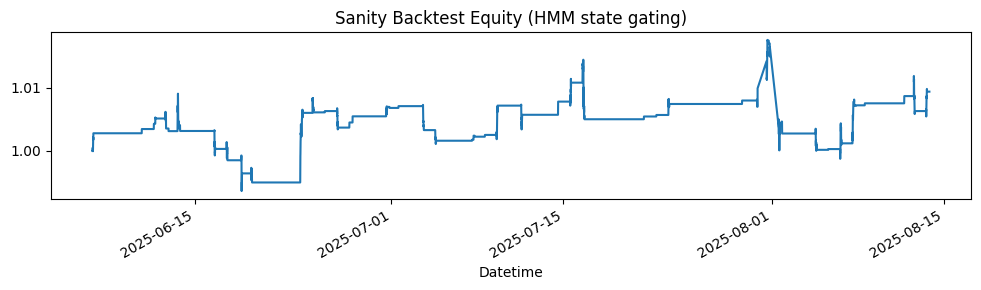

In [17]:
# Sanity backtest: long best-mean-return state, short worst-mean-return state
import numpy as np
import pandas as pd

# Derive daily pnl from states inferred earlier
price = features_df['close']
ret = price.pct_change().fillna(0.0)

# Compute average return per state to label bull/bear regimes
state_means = pd.Series(states, index=features_df.index).to_frame('state').join(ret.rename('ret'))\
    .groupby('state')['ret'].mean().sort_values()
low_s = int(state_means.index[0])
high_s = int(state_means.index[-1])

sig = pd.Series(0, index=features_df.index)
sig[features_df.index[states == high_s]] = 1
sig[features_df.index[states == low_s]] = -1

pos = sig.shift(1).fillna(0.0)
net = (pos * ret)

equity = (1.0 + net).cumprod()

sharpe = (net.mean() / (net.std() + 1e-12)) * np.sqrt(252)
rollmax = equity.cummax()
mdd = float(((equity / rollmax) - 1.0).min())
print({'sharpe': float(sharpe), 'mdd': mdd, 'equity_final': float(equity.iloc[-1])})

ax = equity.plot(figsize=(10,3), title='Sanity Backtest Equity (HMM state gating)')
ax.figure.tight_layout()